In [1]:
from project_path import *
import utils

from utils import *

import importlib

importlib.reload(utils)

from utils import *
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report

from sklearn.metrics import r2_score
import xgboost as xgb

from tqdm import tqdm

# Utils

In [2]:
from sklearn.preprocessing import StandardScaler

def run_linreg(X, y):
    scaler = StandardScaler()
    
    X = scaler.fit_transform(X)
    reg = LinearRegression().fit(X, y)
    
    return reg, scaler

In [3]:
def linreg_importances(reg, cols):
    coefs = reg.coef_
    
    args = np.argsort(np.abs(coefs))[::-1]
    
    for i, arg in enumerate(args):
        print(i, "---", np.round(coefs[arg], 2), "---", cols[arg])

In [4]:
def get_importances(reg, cols, n=5):
    coefs = reg.coef_
    
    args = np.argsort(np.abs(coefs))[::-1]
    
    return np.array(cols)[args][:n]

In [5]:
def getrowind(x, ind):
    if len(x) == 0:
        return np.full(len(x.columns), np.nan)
    
    ind = x.index.searchsorted(ind)
    if ind == len(x):
        ind = len(x) - 1
    
    return x.iloc[ind].to_numpy()

In [6]:
# function for reducing feature size
# it drops correlated columns

def reducex(x, y):
    cols = []

    corrs = []

    for c in x.columns:
        corrs.append(np.abs(np.corrcoef(x[c], y)[0][1]))

    args = np.argsort(corrs)[::-1]

    for arg in args:
        include = True

        for c in cols:
            if np.abs(np.corrcoef(x[x.columns[arg]], x[c])[0][1]) > 0.9:
                include = False

                break

        if include:
            cols.append(x.columns[arg])
            
    print(f"final size: {len(cols) * 1.0 / len(x.columns)}")
    
    return cols

In [7]:
def print_xgb_importances(coefs, cols):    
    args = np.argsort(np.abs(coefs))[::-1]
    
    for i, arg in enumerate(args):
        print(i, "---", np.round(coefs[arg], 2), "---", cols[arg])

In [8]:
def dropna(X):
    s = len(X)
    
    X.dropna(inplace=True)
    
    print(f"final size: {np.round(len(X) / s, 2)} ")

In [9]:
def upgrade_stats(stats):
    stats["res"] = stats["home_teamStats_goal"] - stats["away_teamStats_goal"]
    stats["sum_res"] = stats["home_teamStats_goal"] + stats["away_teamStats_goal"]

    print(1)
    
    stats["hp1"] = stats.apply(lambda x: value_1(x), axis=1)
    stats["hi1"] = stats.apply(lambda x : hand_income1(x), axis=1)

    print(2)

    stats["hp2"] = stats.apply(lambda x: value_2(x), axis=1)
    stats["hi2"] = stats.apply(lambda x : hand_income2(x), axis=1)

    print(3)

    stats["vup"] = stats.apply(lambda x: value_under(x), axis=1)
    stats["vui"] = stats.apply(lambda x : under_income(x), axis=1)

    print(4)

    stats["vop"] = stats.apply(lambda x: value_over(x), axis=1)
    stats["voi"] = stats.apply(lambda x : over_income(x), axis=1)

In [10]:
def get_hyperparams():
    hyperparams = {}
    for pnl, name in plan:
        pnls = []
        for filtration in filtrations:        
            pnls.append(pnl(stats_val, filtration).sum())

        arg = np.argmax(pnls)
        maxpnl = pnls[arg]
        maxfiltration = filtrations[arg]

        if name not in hyperparams:
            hyperparams[name] = {}

        if maxpnl > -50.0:
            hyperparams[name]["maxfiltration"] = maxfiltration
        else:
            hyperparams[name]["maxfiltration"] = -1e6
    
    return hyperparams

In [11]:
def p1(stats, filtration=0.1):
    return ((stats.hp1 > (1.0 + filtration)).astype(int) * stats.hi1)

def p2(stats, filtration=0.1):
    return ((stats.hp2 > (1.0 + filtration)).astype(int) * stats.hi2)

def punder(stats, filtration=0.1):
    return ((stats.vup > (1.0 + filtration)).astype(int) * stats.vui)

def pover(stats, filtration=0.1):
    return ((stats.vop > (1.0 + filtration)).astype(int) * stats.voi)

plan = [
    (p1, "p1"),
    (p2, "p2"),
    (punder, "punder"),
    (pover, "pover")
]

In [12]:
def check_stats(ax, pnl, filtration, title="PNL"):
    ax.set_title(title)

    if filtration > -1.0:
        ax.plot(pd.to_datetime(stats_test.date), pnl(stats_test, filtration).cumsum(), label=f"{filtration}")

    ax.axhline(0.0, c="r", linestyle="--")

    ax.legend()

In [13]:
def printplan(plan):
    w = 2
    row = int(np.ceil(len(plan) / w))

    fig, axs = plt.subplots(row, w, figsize=(17, row * 3.5))

    for i, (pnl, name) in enumerate(plan):
        ax = axs[i // w, i - w * (i // w)]
        check_stats(ax, pnl, hyperparams[name]["maxfiltration"], f"PNL, {name}")

In [142]:
def printbest(plan):
    plt.figure(figsize=(12, 5))
    
    plt.title("Total PNL")
    
    total_pnl_set = False
    
    for pnl, name in plan:
        
        maxfiltration = hyperparams[name]["maxfiltration"]
        
        if maxfiltration > -1.0:
            if total_pnl_set == False:
                total_pnl = pnl(stats_test, maxfiltration).cumsum()
                total_pnl_set = True
            else:
                total_pnl += pnl(stats_test, maxfiltration).cumsum()
                
    plt.plot(pd.to_datetime(stats_test.date), total_pnl)

    plt.axhline(0.0, c="r", linestyle="--")

    plt.show()
    
    return total_pnl.iloc[-1]

In [15]:
def upgrade_stats(stats):
    stats["res"] = stats["home_teamStats_goal"] - stats["away_teamStats_goal"]
    stats["sum_res"] = stats["home_teamStats_goal"] + stats["away_teamStats_goal"]
    
    stats["hp1"] = stats.apply(lambda row: value_1_new(row["f1_open"], row["hand_open"], row["pred_home"], row["pred_away"]), axis=1)
    stats["hi1"] = stats.apply(lambda x : hand_income1(x), axis=1)

    stats["hp2"] = stats.apply(lambda row: value_2_new(row["f2_open"], row["hand_open"], row["pred_home"], row["pred_away"]), axis=1)
    stats["hi2"] = stats.apply(lambda x : hand_income2(x), axis=1)
    
    stats["vup"] = stats.apply(lambda row: value_under_new(row["under_open"], row["total_open"], row["pred_home"], row["pred_away"]), axis=1)
    stats["vui"] = stats.apply(lambda x : under_income(x), axis=1)

    stats["vop"] = stats.apply(lambda row: value_over_new(row["over_open"], row["total_open"], row["pred_home"], row["pred_away"]), axis=1)
    stats["voi"] = stats.apply(lambda x : over_income(x), axis=1)

In [16]:
def relearn_regs(X_train, y_train):
    regs = []
    
    reg = xgb.XGBRegressor()
    reg.fit(X_train, y_train[tcols[0]])
    
    regs.append(reg)
    
    reg = xgb.XGBRegressor()
    reg.fit(X_train, y_train[tcols[1]])
    
    regs.append(reg)
    
    return regs

In [17]:
def relearn_regs_linreg(X_train, y_train):
    regs = []
    
    reg, scaler = run_linreg(X_train, y_train[tcols[0]])
    regs.append((reg, scaler))
    
    reg, scaler = run_linreg(X_train, y_train[tcols[1]])
    regs.append((reg, scaler))
    
    return regs

# Data

In [18]:
data = pd.read_csv('../data_for_alba.csv')

col_to_norm = ['home_teamStats_xgShot', 'away_teamStats_xgShot']

for col in col_to_norm:
    data[col] = data[col] * 1.0292
    
data['home_season'] = data['home'] + "______" + data['season']
data['away_season'] = data['away'] + "______" + data['season']
data['league_season'] = data['league'] + "______" + data['season']

# Data checks

In [20]:
from pandas.api.types import is_numeric_dtype

ncols = []
for c in data.columns:
    if is_numeric_dtype(data[c]):
        ncols.append(c)
        
tcol = "home_teamStats_goal"

restricted = [
    "xg_diff",
    "ind",
    "Unnamed: 0"
]

xcols = []

for c in ncols:
    if c != tcol and c not in restricted:
        xcols.append(c)
        
X = data[xcols]

reg, scaler = run_linreg(X, data[tcol])

# get the most important columns

hcols = get_importances(reg, xcols, 9)

In [21]:
# linreg_importances(reg, xcols)

# F engineering

In [22]:
# print_xgb_importances(reg.feature_importances_, X_train.columns)

In [23]:
# tcols[0]

In [24]:
for c in hcols:
    print(c)

home_teamStats_shotSuccess
home_teamStats_xgShot
home_teamStats_shot
home_teamStats_touchInBoxSuccess
home_teamStats_corner
home_teamStats_passToPenaltyAreaSuccess
home_xg_per_shot
home_teamStats_deepCompletedPassSuccess
home_teamStats_positionalAttacksWithShot


In [25]:
for team in ["home", "away"]:
    data[f"{team}_teamStats_goalrate"] = data[f"{team}_teamStats_goal"] / data[f"{team}_teamStats_passToPenaltyAreaSuccess"]
    data[f"{team}_teamStats_xgShotrate"] = data[f"{team}_teamStats_xgShot"] / data[f"{team}_teamStats_passToPenaltyAreaSuccess"]
    data[f"{team}_teamStats_touchintheboxrate"] = data[f"{team}_teamStats_touchInBoxSuccess"] / data[f"{team}_teamStats_passToPenaltyAreaSuccess"]
    data[f"{team}_teamStats_deeppassxxg"] = data[f"{team}_teamStats_deepCompletedPassSuccess"] * data[f"{team}_xg_per_shot"]
#     data[f"{team}_teamStats_passtopenaltyxxg"] = data[f"{team}_teamStats_passToPenaltyAreaSuccess"] * data[f"{team}_xg_per_shot"]
#     data[f"{team}_teamStats_posattackxxg"] = data[f"{team}_teamStats_positionalAttacksWithShot"] * data[f"{team}_xg_per_shot"]
#     data[f"{team}_teamStats_shotxxg"] = data[f"{team}_teamStats_shot"] * data[f"{team}_xg_per_shot"]
#     data[f"{team}_teamStats_xgovershotSuccess"] = data[f"{team}_teamStats_xgShot"] / data[f"{team}_teamStats_shotSuccess"]
    
new_features = [c.replace("away", "home") for c in data.columns[-4:]]

hcols = np.array(list(hcols) + new_features)

# mirroring the most import columns for away team

acols = []

for c in hcols:
    acols.append(c.replace("home", "away"))

Leage filtering

In [26]:
# data = data[data['league'] == 'England. Premier League']

In [27]:
# data['home'].unique()

# Merge odds

In [28]:
odds = pd.read_csv('../pinnacle_odds_xg_new.csv')

cs = []
for c in list(odds.columns):
    if "open" in c:
        cs.append(c)
        
for c in cs:
    odds[c] = odds[c.replace("open", "close")]
    
data = data.merge(odds, on='ind1', how="left", suffixes=('', '__x'))
bcols = data.columns[-22:-2]

data[bcols] = data[bcols].fillna(-1)

In [29]:
jcols = np.array(list(hcols) + list(acols))

# Feature generation

In [30]:
teams = np.unique(list(data["home_season"]) + list(data["away_season"]))

print("home")

home_perf = {}

for team in teams:    
    x = data[data["home_season"] == team].copy()

    ms = []
    for window_mean in [3, 5, 30, 60]:
        m = x.ewm(halflife=window_mean).mean().shift(1)
        m = m[jcols].copy()
        
        m.columns = [f"{x}_mean_{window_mean}" for x in list(m.columns)]
        
        ms.append(m)

    home_perf[team] = pd.concat(ms, axis=1)
    
home_perf_features = list(home_perf[team].columns)

print("away")

away_perf = {}

for team in teams:
    x = data[data["away_season"] == team].copy()

    ms = []
    for window_mean in [3, 5, 30, 60]:
        m = x.ewm(halflife=window_mean).mean().shift(1)
        m = m[jcols].copy()
        
        m.columns = [f"{x}_mean_{window_mean}" for x in list(m.columns)]
        ms.append(m)

    away_perf[team] = pd.concat(ms, axis=1)
    
away_perf_features = list(away_perf[team].columns)

home
away
joint
done


In [96]:
print("joint")

joint_perf = {}

for team in teams:
    h = data[data["home_season"] == team].copy()
    a = data[data["away_season"] == team].copy()
    
    dh = h[hcols].copy()
    dh.columns = [f"{x.replace('home', 'joint')}" for x in list(dh.columns)] 

    da = a[acols].copy()
    da.columns = [f"{x.replace('away', 'joint')}" for x in list(da.columns)] 
    
    dbase = pd.concat([dh, da])
    
    dh = h[acols].copy()
    dh.columns = [f"{x.replace('away', 'joint_away')}" for x in list(dh.columns)] 

    da = a[hcols].copy()
    da.columns = [f"{x.replace('home', 'joint_away')}" for x in list(da.columns)] 

    dbase = pd.concat([dbase, pd.concat([dh, da])], axis=1)
    
    ms = []
    for window_mean in [3, 5, 30, 60]:
        m = dbase.ewm(halflife=window_mean).mean().shift(1)
        
        m.columns = [f"{x}_mean_{window_mean}" for x in list(m.columns)]
        ms.append(m)

    joint_perf[team] = pd.concat(ms, axis=1)
    
joint_perf_features = list(joint_perf[team].columns)

print("done")

joint
done


In [97]:
# seasons_perf = {}

# for team in teams:
#     t = team.split("______")[0]
    
#     h = data[data["home"] == t].copy()
#     a = data[data["away"] == t].copy()
    
#     dh = h[hcols].copy()
#     dh.columns = [f"{x.replace('home', 'joint')}" for x in list(dh.columns)] 

#     da = a[acols].copy()
#     da.columns = [f"{x.replace('away', 'joint')}" for x in list(da.columns)] 
    
#     dbase = pd.concat([dh, da])

#     ms = []
#     for window_mean in [5, 10, 30, 60, 100]:
#         m = dbase.ewm(halflife=window_mean).mean().shift(1)
        
#         m.columns = [f"{x}_season_mean_{window_mean}" for x in list(m.columns)]
#         ms.append(m)

#     seasons_perf[team] = pd.concat(ms, axis=1)
    
# seasons_perf_features = list(seasons_perf[team].columns)

In [98]:
xcols = []

for team in ["home", "away"]:
    for c in home_perf_features:
        xcols.append(f"{team}_team_playing_home_f_{c}")

    for c in away_perf_features:
        xcols.append(f"{team}_team_playing_away_f_{c}")
        
    for c in joint_perf_features:
        xcols.append(f"{team}_team_playing_joint_f_{c}")
        
#     for c in seasons_perf_features:
#         xcols.append(f"{team}_team_playing_season_f_{c}")
        
# xcols.append("league")

In [99]:
data["league_str"] = data["league"]

In [100]:
tcols = [
    "home_teamStats_goal",
    "away_teamStats_goal",
]

tcols += list(bcols)

tcols += ["date", "league_str"]
tcols += ["home_teamStats_xgShot", "away_teamStats_xgShot"]

In [101]:
targets = []

x = []

ind = 0

for index, row in data.iterrows():
    ind += 1
    
    scale = 100000
    if int(scale * ind / len(data)) % int(scale / 10) == 0:
        print(np.round(100 * ind / len(data)))
    
    home_team = row["home_season"]
    away_team = row["away_season"]
    
    features = []
    
    skip_row = False
    
    for team in [home_team, away_team]:
        if team not in home_perf or team not in away_perf:
            skip_row = True
            break
            
        features += list(getrowind(home_perf[team], index))
        features += list(getrowind(away_perf[team], index))
        features += list(getrowind(joint_perf[team], index))
#         features += list(getrowind(seasons_perf[team], index))
    
#     features.append(row["league"])
        
    if skip_row:
        continue
        
    x.append(features)
    targets.append(row[tcols])

x = np.array(x)

10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0


In [102]:
X = pd.DataFrame(x, columns=xcols)

In [103]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92952 entries, 0 to 92951
Columns: 624 entries, home_team_playing_home_f_home_teamStats_shotSuccess_mean_3 to away_team_playing_joint_f_joint_away_teamStats_deeppassxxg_mean_60
dtypes: float64(624)
memory usage: 442.5 MB


In [104]:
X[tcols] = targets

In [105]:
# for c in xcols[:-1]:
#     X[c] = X[c].astype(np.float)

In [106]:
# X["league_str"] = X["league"]

In [107]:
from sklearn.preprocessing import LabelEncoder

# c = "league_str"
# if c not in tcols:
#     tcols.append(c)

# X["league"] = X["league"].astype("category")

# encoder = LabelEncoder()
# X.league = encoder.fit_transform(X.league)

dropna(X)

final size: 0.92 


# Train, val, test split

In [108]:
x = X.drop(tcols, axis=1)

X_train, X_test, y_train, y_test = train_test_split(x, X[tcols], test_size=0.33, random_state=42, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42, shuffle=False)

# Linreg, predictions

In [109]:
regs = []

In [110]:
reg, scaler = run_linreg(X_train, y_train[tcols[0]])

In [111]:
# print_xgb_importances(reg.feature_importances_, X_train.columns)

In [112]:
y_home_pred = reg.predict(scaler.transform(X_test)).flatten()

In [113]:
r2_score(y_test[tcols[0]], y_home_pred)

0.1710435190742654

In [114]:
regs.append((reg, scaler))

In [115]:
reg, scaler = run_linreg(X_train, y_train[tcols[1]])

In [116]:
y_away_pred = reg.predict(scaler.transform(X_test)).flatten()

In [117]:
r2_score(y_test[tcols[1]], y_away_pred)

0.1432374076129549

In [118]:
regs.append((reg, scaler))

# Testing winning team prediction by Linreg

In [119]:
stats_val = y_val.copy()

stats_val["pred_home"] = regs[0][0].predict(regs[0][1].transform(X_val))
stats_val["pred_away"] = regs[1][0].predict(regs[0][1].transform(X_val))

stats_val = stats_val[stats_val.f1_open > -1]

In [120]:
upgrade_stats(stats_val)

having more data for predict is crucial, so we append val test to learning model

In [121]:
new_regs = relearn_regs_linreg(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

In [122]:
stats_test = y_test.copy()

stats_test["pred_home"] = new_regs[0][0].predict(new_regs[0][1].transform(X_test))
stats_test["pred_away"] = new_regs[1][0].predict(new_regs[0][1].transform(X_test))

stats_test = stats_test[stats_test.f1_open > -1]

In [123]:
upgrade_stats(stats_test)

In [124]:
filtrations = np.geomspace(1, 10, 1000) - 1
# filtrations = np.array(list(-filtrations[filtrations < 1]) + list(filtrations))

In [132]:
# def get_hyperparams():
#     hyperparams = {}
#     for pnl, name in plan:
#         pnls = []
#         for filtration in filtrations:        
#             pnls.append(pnl(stats_val, filtration).sum())

#         arg = np.argmax(pnls)
#         maxpnl = pnls[arg]
#         maxfiltration = filtrations[arg]

#         if name not in hyperparams:
#             hyperparams[name] = {}

#         if maxpnl > -50.0:
#             hyperparams[name]["maxfiltration"] = maxfiltration
#         else:
#             hyperparams[name]["maxfiltration"] = -1e6
    
#     return hyperparams

хуйня с 10 %, нужно расскоментить и можно покрутить скейл

колонкой выше можно вернуть все обратно

In [144]:
scale = 1000

def p1_trades(stats, filtration=0.1):
    trades = (stats.hp1 > (1.0 + filtration)).astype(int)
    if trades.sum() < scale:
        return 1e10
    
    return trades.sum()

def p2_trades(stats, filtration=0.1):
    trades = (stats.hp2 > (1.0 + filtration)).astype(int) 
    if trades.sum() < scale:
        return 1e10
              
    return trades.sum()

def punder_trades(stats, filtration=0.1):
    trades = (stats.vup > (1.0 + filtration)).astype(int)
    if trades.sum() < scale:
        return 1e10
              
    return trades.sum()

def pover_trades(stats, filtration=0.1):
    trades = (stats.vop > (1.0 + filtration)).astype(int)
    if trades.sum() < scale:
        return 1e10
              
    return trades.sum()

plan2 = [
    p1_trades,
    p2_trades,
    punder_trades,
    pover_trades
]

In [145]:
def get_hyperparams():
    hyperparams = {}
    for i, (pnl, name) in enumerate(plan):
        pnls = []
        for filtration in filtrations:        
            pnls.append(pnl(stats_val, filtration).sum() / plan2[i](stats_val, filtration))

        arg = np.argmax(pnls)
        maxpnl = pnls[arg]
        maxfiltration = filtrations[arg]

        if name not in hyperparams:
            hyperparams[name] = {}

        if maxpnl > 0.1:
            hyperparams[name]["maxfiltration"] = maxfiltration
        else:
            hyperparams[name]["maxfiltration"] = -1e6
    
    return hyperparams

In [146]:
hyperparams = get_hyperparams()

In [147]:
hyperparams

{'p1': {'maxfiltration': 0.21082975023203998},
 'p2': {'maxfiltration': 0.23336349791377575},
 'punder': {'maxfiltration': 0.22204468663148824},
 'pover': {'maxfiltration': 0.1942000281335321}}

In [148]:
totalpnl

1711.0985000000032

Stat report


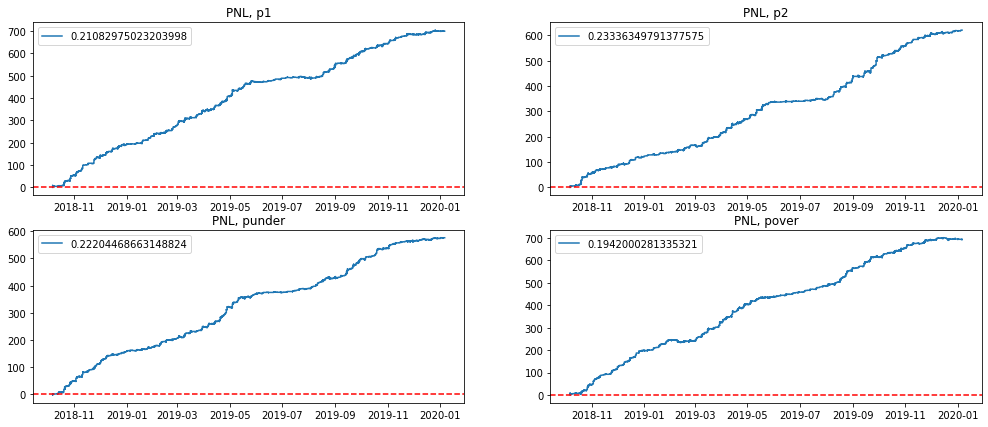

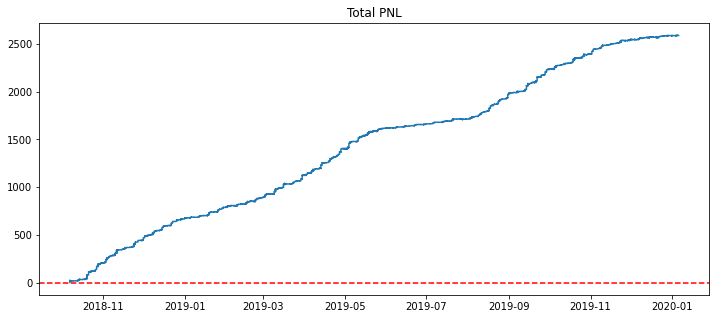

Turnover: 11505
PNL / Turnover ratio:, 0.23


In [149]:
print("Stat report")
printplan(plan)
totalpnl = printbest(plan)

p1_thr = hyperparams['p1']['maxfiltration']
p2_thr = hyperparams['p2']['maxfiltration']
under_thr = hyperparams['punder']['maxfiltration']
over_thr = hyperparams['pover']['maxfiltration']

turnover = len(stats_test[stats_test['hp1'] > 1+p1_thr]) + \
len(stats_test[stats_test['hp2'] > 1+p2_thr]) + \
len(stats_test[stats_test['vup'] > 1+under_thr]) + \
len(stats_test[stats_test['vop'] > 1+over_thr])

print(f"Turnover: {turnover}")
print(f"PNL / Turnover ratio:, {np.round(totalpnl / turnover, 2)}")

13730

In [498]:
total_pnl_set = False

for pnl, name in plan:
    maxfiltration = hyperparams[name]["maxfiltration"]

    if maxfiltration > -1.0:
        if total_pnl_set == False:
            total_pnl = pnl(stats_test, maxfiltration)
            total_pnl_set = True
        else:
            total_pnl += pnl(stats_test, maxfiltration)

In [499]:
stats_test["max_pnl"] = total_pnl

In [501]:
g = stats_test.groupby("league_str")

In [502]:
leagues = list(g.groups.keys())
pnls = []

for league in leagues:
    gr = g.get_group(league)
    
    pnls.append(gr.max_pnl.sum())

args = np.argsort(pnls)[::-1]

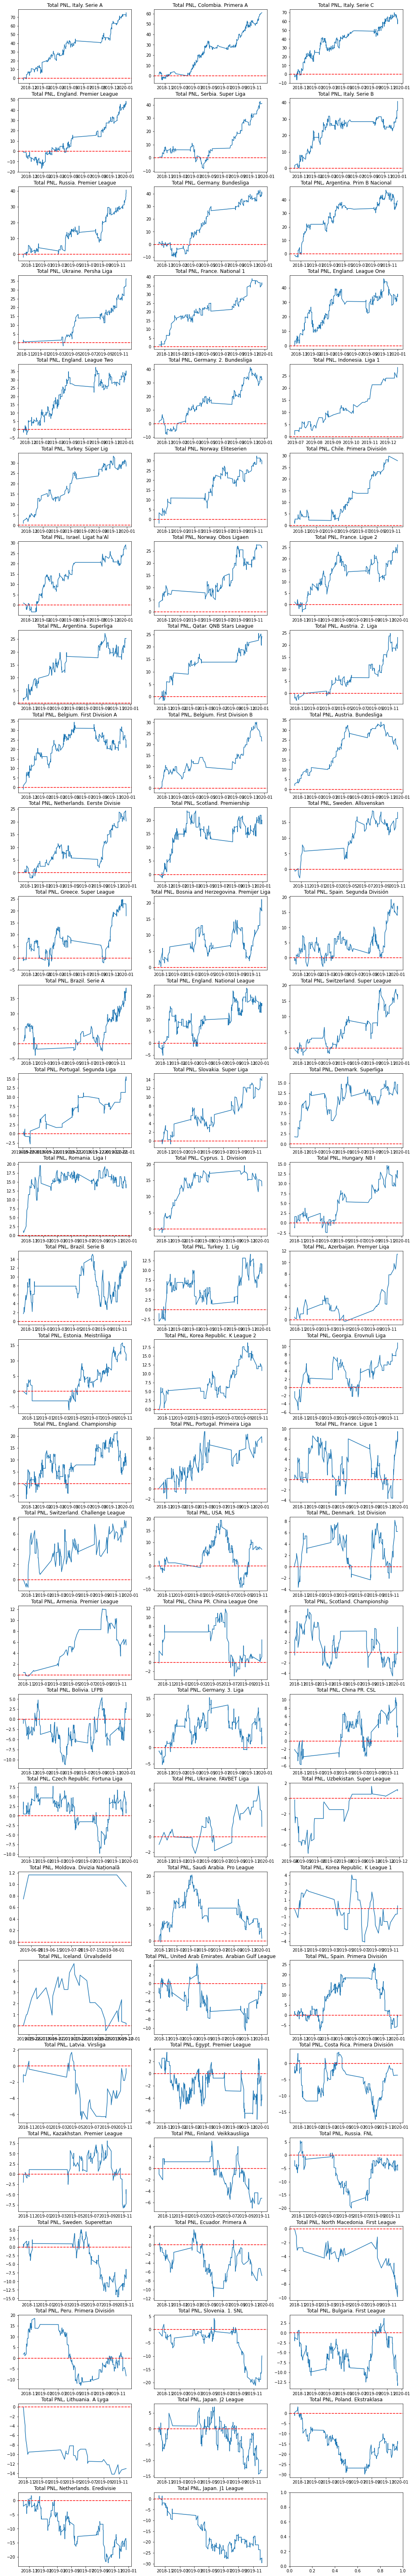

In [506]:
w = 3
row = int(np.ceil(len(args) / w))

fig, axs = plt.subplots(row, w, figsize=(17, row * 4))

for i, arg in enumerate(args):
    ax = axs[i // w, i - w * (i // w)]
    
    league = leagues[arg]
    gr = g.get_group(league)

    ax.set_title(f"Total PNL, {league}")
    
    ax.plot(pd.to_datetime(gr.date), gr.max_pnl.cumsum())

    ax.axhline(0.0, c="r", linestyle="--")
    
# plt.savefig("all_leages.jpg", dpi=300)
plt.show()

accuracy 

In [731]:
X_train, X_test, y_train, y_test = train_test_split(x, X[tcols], test_size=0.33, random_state=42, shuffle=False)

In [732]:
diff = y_test[tcols[0]] - y_test[tcols[1]]

In [733]:
stats = diff.to_frame("d")
stats["pred"] = y_home_pred - y_away_pred
stats = stats[stats.d != 0.0]

print(classification_report(stats.d > 0.0, stats.pred > 0.0))

              precision    recall  f1-score   support

       False       0.57      0.39      0.46      8386
        True       0.66      0.80      0.72     12496

    accuracy                           0.64     20882
   macro avg       0.62      0.60      0.59     20882
weighted avg       0.62      0.64      0.62     20882



# Xgboost, predictions

In [39]:
regs = []

In [40]:
reg = xgb.XGBRegressor()
reg.fit(X_train, y_train[tcols[0]])

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [41]:
print_xgb_importances(reg.feature_importances_, X_train.columns)

0 --- 0.05 --- home_team_playing_joint_f_joint_teamStats_xgShot_mean_60
1 --- 0.02 --- home_team_playing_joint_f_joint_teamStats_shotSuccess_mean_60
2 --- 0.02 --- home_team_playing_joint_f_joint_teamStats_deeppassxxg_mean_60
3 --- 0.01 --- away_team_playing_joint_f_joint_teamStats_xgShot_mean_60
4 --- 0.01 --- home_team_playing_joint_f_joint_teamStats_deepCompletedPassSuccess_mean_30
5 --- 0.01 --- away_team_playing_joint_f_joint_teamStats_shot_mean_60
6 --- 0.01 --- away_team_playing_joint_f_joint_teamStats_passToPenaltyAreaSuccess_mean_60
7 --- 0.01 --- home_team_playing_joint_f_joint_teamStats_goalrate_mean_60
8 --- 0.01 --- away_team_playing_joint_f_joint_teamStats_touchInBoxSuccess_mean_30
9 --- 0.01 --- away_team_playing_joint_f_joint_teamStats_corner_mean_60
10 --- 0.01 --- home_team_playing_home_f_home_teamStats_passToPenaltyAreaSuccess_mean_60
11 --- 0.01 --- away_team_playing_joint_f_joint_teamStats_passToPenaltyAreaSuccess_mean_30
12 --- 0.01 --- away_team_playing_joint_f_j

In [42]:
y_home_pred = reg.predict(X_test).flatten()

In [43]:
r2_score(y_test[tcols[0]], y_home_pred)

0.08722691256119997

In [44]:
regs.append(reg)

In [45]:
reg = xgb.XGBRegressor()
reg.fit(X_train, y_train[tcols[1]])

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [46]:
y_away_pred = reg.predict(X_test).flatten()

In [47]:
r2_score(y_test[tcols[1]], y_away_pred)

-0.00501504940678088

In [48]:
regs.append(reg)

# Testing winning team prediction by Xgboost

In [49]:
stats_val = y_val.copy()

stats_val["pred_home"] = regs[0].predict(X_val)
stats_val["pred_away"] = regs[1].predict(X_val)

stats_val = stats_val[stats_val.f1_open > -1]

In [50]:
upgrade_stats(stats_val)

having more data for predict is crucial, so we append val test to learning model

In [51]:
new_regs = relearn_regs(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

In [52]:
stats_test = y_test.copy()

stats_test["pred_home"] = new_regs[0].predict(X_test)
stats_test["pred_away"] = new_regs[1].predict(X_test)

stats_test = stats_test[stats_test.f1_open > -1]

In [53]:
upgrade_stats(stats_test)

In [54]:
filtrations = np.geomspace(1, 10, 1000) - 1
# filtrations = np.array(list(-filtrations[filtrations < 1]) + list(filtrations))

In [55]:
hyperparams = get_hyperparams()

In [56]:
hyperparams

{'p1': {'maxfiltration': 0.17508713090480765},
 'p2': {'maxfiltration': 0.099109700929497},
 'punder': {'maxfiltration': 0.20248614203741222},
 'pover': {'maxfiltration': 0.0023075482838652572}}

Stat report


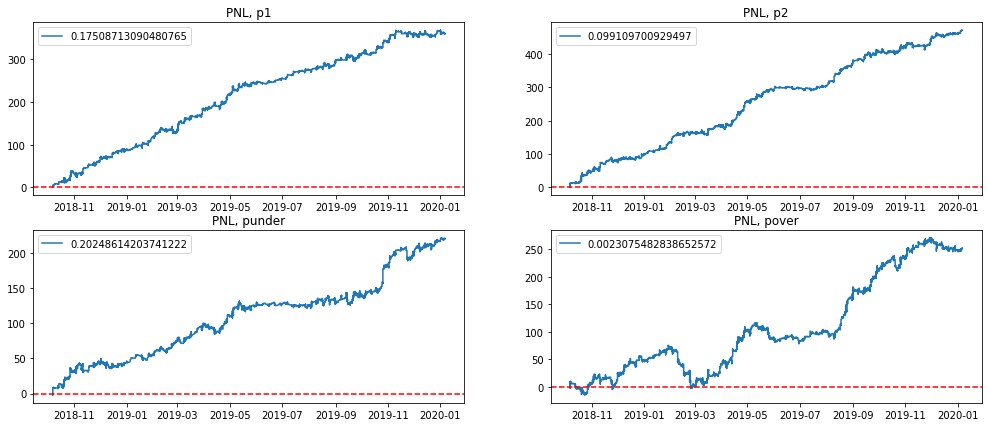

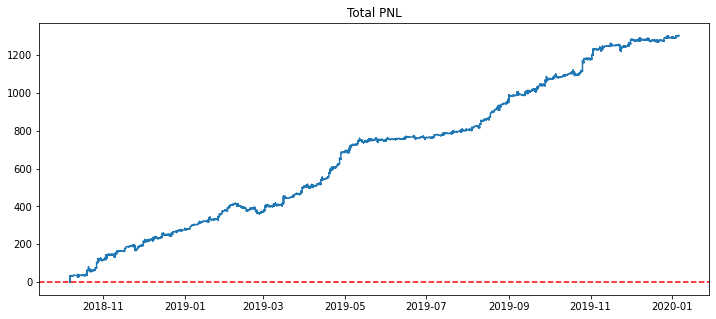

In [57]:
print("Stat report")
printplan(plan)
printbest(plan)

In [1075]:
total_pnl_set = False

for pnl, name in plan:
    maxfiltration = hyperparams[name]["maxfiltration"]
    
    if maxfiltration > -1.0:
        if total_pnl_set == False:
            total_pnl = pnl(stats_test, maxfiltration)
            total_pnl_set = True
        else:
            total_pnl += pnl(stats_test, maxfiltration)

In [1076]:
stats_test["total_pnl"] = total_pnl

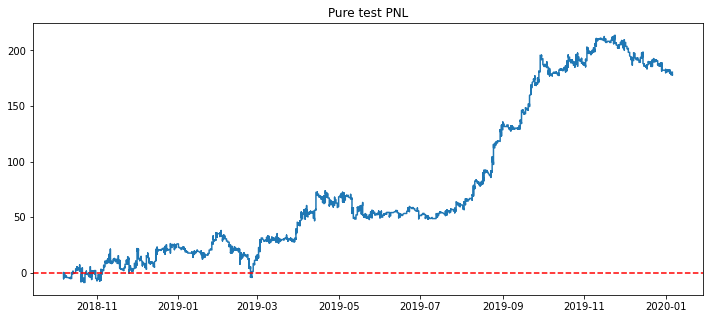

In [1077]:
plt.figure(figsize=(12, 5))

plt.title("Pure test PNL")

plt.plot(pd.to_datetime(stats.date), total_pnl.cumsum())

plt.axhline(0.0, c="r", linestyle="--")

plt.show()

In [1066]:
total_pnl_set = False

for pnl, name in plan:
    maxfiltration = hyperparams[name]["maxfiltration"]
    
    if maxfiltration > -1.0:
        if total_pnl_set == False:
            total_pnl = pnl(stats_val, maxfiltration)
            total_pnl_set = True
        else:
            total_pnl += pnl(stats_val, maxfiltration)

In [1068]:
stats_val["max_pnl"] = total_pnl

In [1069]:
g = stats_val.groupby("league_str")

In [1087]:
leagues = np.array(list(g.groups.keys()))
pnls = []

for league in leagues:
    gr = g.get_group(league)
    
    pnls.append(gr.max_pnl.sum())

pnls = np.array(pnls)

In [1088]:
filtered_leagues = leagues[pnls > -1]

In [1089]:
total_pnl = stats_test.apply(lambda row: row["total_pnl"] * int(row["league_str"] in filtered_leagues), axis=1)

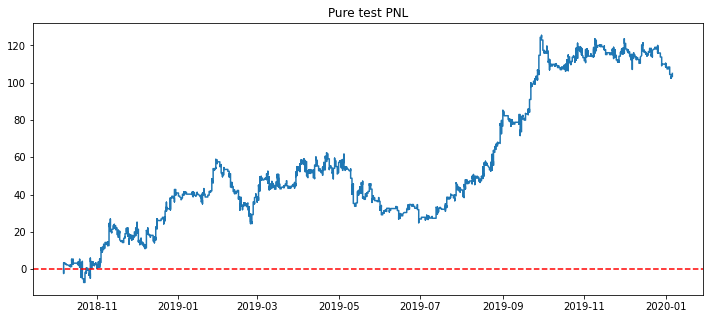

In [1090]:
plt.figure(figsize=(12, 5))

plt.title("Pure test PNL")

plt.plot(pd.to_datetime(stats.date), total_pnl.cumsum())

plt.axhline(0.0, c="r", linestyle="--")

plt.show()

In [853]:
stats = y_test.copy()

stats["pred_sum"] = y_sum_pred

stats = stats[stats.f1_open > -1]

stats["res"] = stats["home_teamStats_goal"] - stats["away_teamStats_goal"]
stats["sum_res"] = stats["home_teamStats_goal"] + stats["away_teamStats_goal"]

print(1)

stats["vusp"] = stats.apply(lambda x: value_under_sum(x), axis=1)
stats["vusi"] = stats.apply(lambda x : hand_income1(x), axis=1)

1


In [751]:
def pundersum(filtration=0.1):
    return ((stats.vusp > (1.0 + filtration)).astype(int) * stats.vusi)

In [754]:
plan2 = [
    (pundersum, "p under sum")
]

In [1092]:
def check_one_stat(pnl, filtration, title="PNL"):
    plt.figure(figsize=(12, 6))
    plt.title(title)
    
    plt.plot(pd.to_datetime(stats_test.date), pnl(stats_test, filtration).cumsum(), label=f"{filtration}")
    
    plt.axhline(0.0, c="r", linestyle="--")

    plt.legend()
    plt.show()

In [762]:
filtrations = [-0.2, -0.1, -0.05, -0.03, 0.0, 0.03, 0.05, 0.1, 0.2, 0.3, 0.5, 1.0, 2.0, 3.0]

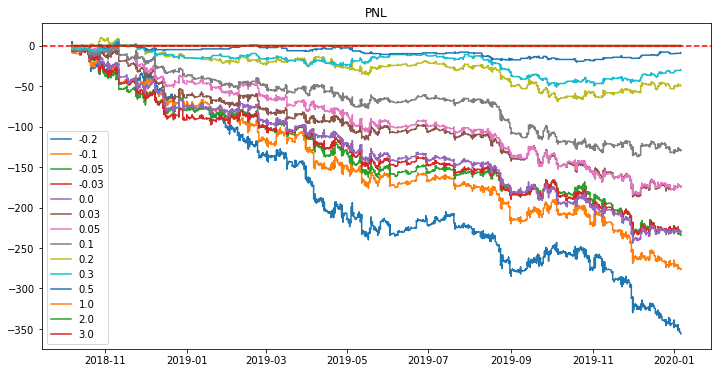

In [763]:
check_one_stat(pundersum)

# Experiments

In [1174]:
x = X.drop(tcols, axis=1)

In [849]:
X_train, X_test, y_train, y_test = train_test_split(x, X[tcols], test_size=0.33, random_state=42, shuffle=False)

In [966]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42, shuffle=False)

In [850]:
reg = xgb.XGBRegressor()
reg.fit(X_train, y_train.home_teamStats_goal + y_train.away_teamStats_goal)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [851]:
y_sum_pred = reg.predict(X_test).flatten()

In [852]:
r2_score(y_test.home_teamStats_goal + y_test.away_teamStats_goal, y_away_pred)

-0.8522898098846914

In [948]:
total_pnl_set = False

for pnl, name in plan:
    pnls = []
    for filtration in filtrations:        
        pnls.append(pnl(filtration).sum())

    arg = np.argmax(pnls)
    maxpnl = pnls[arg]
    maxfiltration = filtrations[arg]
    
    if maxpnl > 0.0:
        hyperparams[name]["maxfiltration"] = maxfiltration
    else:
        hyperparams[name]["maxfiltration"] = -1e6

    if maxpnl > 0.0:
        if total_pnl_set == False:
            total_pnl = pnl(maxfiltration)
            total_pnl_set = True
        else:
            total_pnl += pnl(maxfiltration)

# Linreg model test

In [634]:
reg = run_linreg(x, y)

In [635]:
linreg_importances(reg, x.columns)

0 --- 0.55 --- home_team_playing_home_f_home_teamStats_deepCompletedPassSuccess_mean_5
1 --- -0.39 --- home_team_playing_home_f_home_teamStats_shot_mean_5
2 --- -0.38 --- home_team_playing_home_f_home_teamStats_touchInBoxSuccess_mean_5
3 --- 0.34 --- home_team_playing_home_f_home_teamStats_shotSuccess_mean_5
4 --- 0.33 --- home_team_playing_home_f_home_teamStats_shot_mean_3
5 --- -0.31 --- home_team_playing_away_f_away_teamStats_touchInBoxSuccess_mean_3
6 --- -0.31 --- away_team_playing_away_f_away_teamStats_xgShot_mean_3
7 --- 0.27 --- away_team_playing_away_f_away_teamStats_touchInBoxSuccess_mean_5
8 --- 0.25 --- home_team_playing_away_f_away_teamStats_deepCompletedPassSuccess_mean_5
9 --- -0.24 --- away_team_playing_home_f_home_teamStats_xgShot_mean_3
10 --- 0.2 --- away_team_playing_away_f_away_teamStats_shotSuccess_mean_3
11 --- -0.2 --- home_team_playing_home_f_home_teamStats_deepCompletedPassSuccess_mean_3
12 --- -0.19 --- home_team_playing_home_f_home_teamStats_corner_mean_3
13

visualizing predictions and errors

In [640]:
y_pred = reg.predict(x).flatten()

0.0 	 -4.668
0.1 	 -0.215
0.2 	 0.518
0.3 	 1.078
0.4 	 1.53
0.5 	 1.939
0.6 	 2.432
0.7 	 2.933
0.8 	 3.501
0.9 	 4.396
1.0 	 9.782


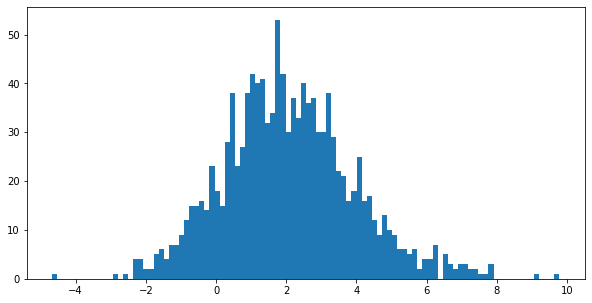

In [641]:
hist(y_pred)

0.0 	 -5.668
0.1 	 -1.786
0.2 	 -1.015
0.3 	 -0.481
0.4 	 0.031
0.5 	 0.553
0.6 	 0.99
0.7 	 1.415
0.8 	 1.947
0.9 	 3.01
1.0 	 6.897


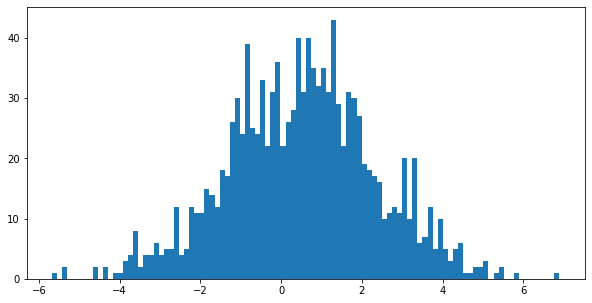

In [642]:
hist(y_pred - y)

In [643]:
x = X.drop(tcols, axis=1)

# Test winning team prediction by Linreg Model

In [644]:
reg_home = run_linreg(x, X[tcols[0]])
reg_away = run_linreg(x, X[tcols[1]])

In [673]:
yp_home = np.maximum(0.0, reg_home.predict(x).flatten())
yp_away = np.maximum(0.0, reg_away.predict(x).flatten())

In [674]:
reg_home.score(x, X[tcols[0]])

-1.2645523833950127

In [675]:
reg_away.score(x, X[tcols[1]])

-8.96291860211674

In [676]:
diff = X[tcols[0]] - X[tcols[1]]

In [677]:
stats = diff.to_frame("d")

In [678]:
stats["pred"] = yp_home - yp_away

In [679]:
stats = stats[stats.d != 0.0]

In [680]:
from sklearn.metrics import classification_report

In [682]:
print(classification_report(stats.d > 0.0, stats.pred > 0.0))

              precision    recall  f1-score   support

       False       0.45      0.96      0.61       358
        True       0.92      0.26      0.41       574

    accuracy                           0.53       932
   macro avg       0.69      0.61      0.51       932
weighted avg       0.74      0.53      0.49       932



# Old code

In [163]:
def all_features(row):
    global data
    data2 = data
    index = row['index']
    if (index % 1000 == 0):
        print(index)
    player1 = row['team_season']
    player2 = row['opp_season']
    #print(player1, player2)
    data2 = data2[data2['index'] < index - 1]
    d1 = data2[data2['team_season'] == player1]
    d2 = data2[data2['opp_season'] == player2]
    d3 = data2[data2['opp_season'] == player1]
    d4 = data2[data2['team_season'] == player2]
    count_1 = d1.home_teamStats_xgShot.count()
    count_2 = d2.away_teamStats_xgShot.count()
    count_3 = d3.away_teamStats_xgShot.count()
    count_4 = d4.home_teamStats_xgShot.count()
    
    mean_home_3 = d1[-3:].home_teamStats_xgShot.mean()
    mean_ag_away_3 = d2[-3:].home_teamStats_xgShot.mean()
    mean_home_all = d1.home_teamStats_xgShot.mean()
    mean_ag_away_all = d2.home_teamStats_xgShot.mean()
    
    mean_home_3_rev = d3[-3:].away_teamStats_xgShot.mean()
    mean_ag_away_3_rev = d4[-3:].away_teamStats_xgShot.mean()
    mean_home_all_rev = d3.away_teamStats_xgShot.mean()
    mean_ag_away_all_rev = d4.away_teamStats_xgShot.mean()
    
    mean_away_3 = d2[-3:].away_teamStats_xgShot.mean()
    mean_ag_home_3 = d1[-3:].away_teamStats_xgShot.mean()
    mean_away_all = d2.away_teamStats_xgShot.mean()
    mean_ag_home_all = d1.away_teamStats_xgShot.mean()
    
    mean_away_3_rev = d4[-3:].home_teamStats_xgShot.mean()
    mean_ag_home_3_rev = d3[-3:].home_teamStats_xgShot.mean()
    mean_away_all_rev = d4.home_teamStats_xgShot.mean()
    mean_ag_home_all_rev = d3.home_teamStats_xgShot.mean()
    
    return np.array([mean_home_3, mean_ag_away_3, mean_home_all, mean_ag_away_all,
                    mean_home_3_rev, mean_ag_away_3_rev, mean_home_all_rev, mean_ag_away_all_rev,
                    mean_away_3, mean_ag_home_3, mean_away_all, mean_ag_home_all,
                    mean_away_3_rev, mean_ag_home_3_rev, mean_away_all_rev, mean_ag_home_all_rev,
                    count_1, count_2, count_3, count_4])


In [149]:
w = data.apply(all_features, axis=1)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000


In [27]:
data['xg_stats'] = w

def extract(s, i):
    return s[i]

data['mean_home_3_xg'] = data['xg_stats'].apply(lambda x: extract(x, 0))
data['mean_ag_away_3_xg'] = data['xg_stats'].apply(lambda x: extract(x, 1))
data['mean_home_all_xg'] = data['xg_stats'].apply(lambda x: extract(x, 2))
data['mean_ag_away_all_xg'] = data['xg_stats'].apply(lambda x: extract(x, 3))

data['mean_home_3_rev_xg'] = data['xg_stats'].apply(lambda x: extract(x, 4))
data['mean_ag_away_3_rev_xg'] = data['xg_stats'].apply(lambda x: extract(x, 5))
data['mean_home_all_rev_xg'] = data['xg_stats'].apply(lambda x: extract(x, 6))
data['mean_ag_away_all_rev_xg'] = data['xg_stats'].apply(lambda x: extract(x, 7))

data['mean_away_3_xg'] = data['xg_stats'].apply(lambda x: extract(x, 8))
data['mean_ag_home_3_xg'] = data['xg_stats'].apply(lambda x: extract(x, 9))
data['mean_away_all_xg'] = data['xg_stats'].apply(lambda x: extract(x, 10))
data['mean_ag_home_all_xg'] = data['xg_stats'].apply(lambda x: extract(x, 11))

data['mean_away_3_rev_xg'] = data['xg_stats'].apply(lambda x: extract(x, 12))
data['mean_ag_home_3_rev_xg'] = data['xg_stats'].apply(lambda x: extract(x, 13))
data['mean_away_all_rev_xg'] = data['xg_stats'].apply(lambda x: extract(x, 14))
data['mean_ag_home_all_rev_xg'] = data['xg_stats'].apply(lambda x: extract(x, 15))

data['count_home_home'] = data['xg_stats'].apply(lambda x: extract(x, 16))
data['count_away_away'] = data['xg_stats'].apply(lambda x: extract(x, 17))
data['count_home_away'] = data['xg_stats'].apply(lambda x: extract(x, 18))
data['count_away_home'] = data['xg_stats'].apply(lambda x: extract(x, 19))



In [42]:
def extract(s, i):
    return s[i]

In [28]:
data

,Unnamed: 0,index,league,home,away,country,season,match_competitionFormat,match_competitionId,date,...,mean_away_all_xg,mean_ag_home_all_xg,mean_away_3_rev_xg,mean_ag_home_3_rev_xg,mean_away_all_rev_xg,mean_ag_home_all_rev_xg,count_home_home,count_away_away,count_home_away,count_away_home
0,45433,0,USA. MLS,LA GalaxyUSA,Chicago FireUSA,USA,2015,domestic_league,33.0,2015-03-07,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
1,46050,1,USA. MLS,DC UnitedUSA,Montreal ImpactUSA,USA,2015,domestic_league,33.0,2015-03-07,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2,83727,2,USA. MLS,WhitecapsUSA,TorontoUSA,USA,2015,domestic_league,33.0,2015-03-07,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
3,46177,3,USA. MLS,Philadelphia UnionUSA,Colorado RapidsUSA,USA,2015,domestic_league,33.0,2015-03-07,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
4,46521,4,USA. MLS,Houston DynamoUSA,Columbus CrewUSA,USA,2015,domestic_league,33.0,2015-03-08,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92947,8955,92947,Italy. Serie A,AtalantaITA,ParmaITA,ITA,2019/2020,domestic_league,13.0,2020-01-06,...,0.939145,0.901836,1.235040,1.087521,1.675309,1.430588,8.0,8.0,9.0,9.0
92948,8802,92948,Italy. Serie A,JuventusITA,CagliariITA,ITA,2019/2020,domestic_league,13.0,2020-01-06,...,0.906982,1.116682,1.526647,2.723949,1.333386,1.651294,8.0,8.0,9.0,9.0
92949,7502,92949,Israel. Ligat ha'Al,Maccabi HaifaISR,Maccabi Tel AvivISR,ISR,2019/2020,domestic_league,117.0,2020-01-06,...,1.731629,1.408534,1.571245,0.675841,1.648006,0.646109,7.0,8.0,9.0,8.0
92950,9357,92950,Italy. Serie A,LecceITA,UdineseITA,ITA,2019/2020,domestic_league,13.0,2020-01-06,...,0.805349,2.162606,1.094383,2.888621,1.239614,2.639326,8.0,8.0,9.0,9.0


In [29]:
data['count_home'] = data['count_home_away'] + data['count_home_home']
data['count_away'] = data['count_away_away'] + data['count_away_home']

In [30]:
data.to_csv('data_for_alba_with_means.csv')

In [253]:
data = pd.read_csv('data_for_alba_with_means.csv')

In [254]:
data

,Unnamed: 0,Unnamed: 0.1,index,league,home,away,country,season,match_competitionFormat,match_competitionId,...,mean_away_3_rev_xg,mean_ag_home_3_rev_xg,mean_away_all_rev_xg,mean_ag_home_all_rev_xg,count_home_home,count_away_away,count_home_away,count_away_home,count_home,count_away
0,0,45433,0,USA. MLS,LA GalaxyUSA,Chicago FireUSA,USA,2015,domestic_league,33.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
1,1,46050,1,USA. MLS,DC UnitedUSA,Montreal ImpactUSA,USA,2015,domestic_league,33.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2,2,83727,2,USA. MLS,WhitecapsUSA,TorontoUSA,USA,2015,domestic_league,33.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
3,3,46177,3,USA. MLS,Philadelphia UnionUSA,Colorado RapidsUSA,USA,2015,domestic_league,33.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
4,4,46521,4,USA. MLS,Houston DynamoUSA,Columbus CrewUSA,USA,2015,domestic_league,33.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92947,92947,8955,92947,Italy. Serie A,AtalantaITA,ParmaITA,ITA,2019/2020,domestic_league,13.0,...,1.235040,1.087521,1.675309,1.430588,8.0,8.0,9.0,9.0,17.0,17.0
92948,92948,8802,92948,Italy. Serie A,JuventusITA,CagliariITA,ITA,2019/2020,domestic_league,13.0,...,1.526647,2.723949,1.333386,1.651294,8.0,8.0,9.0,9.0,17.0,17.0
92949,92949,7502,92949,Israel. Ligat ha'Al,Maccabi HaifaISR,Maccabi Tel AvivISR,ISR,2019/2020,domestic_league,117.0,...,1.571245,0.675841,1.648006,0.646109,7.0,8.0,9.0,8.0,16.0,16.0
92950,92950,9357,92950,Italy. Serie A,LecceITA,UdineseITA,ITA,2019/2020,domestic_league,13.0,...,1.094383,2.888621,1.239614,2.639326,8.0,8.0,9.0,9.0,17.0,17.0


# еще один коммент епт

следующая штука немного сложная, но по формату такая же
у нас опять есть строка - матч
функция берет все матчи, сыгранные до тура какого-то и расставляет рейтинги защиты и атаки в соответствии с той линейной моделью, которую я кидал
а потом подставляет соответствующие рейтинги и предиктит для текущего матча голы хозяев и гостей (если не совсем понятно, лучше к тому гитхабу обратиться)

чтобы оценить текущую форму, а не за весь чемпионат, я делаю такую же оценку, только не за последние все туры, а за последние n туров, эта оценка пихается в stats_pred_home_3 и stats_pred_away_3 соответственно
если данных не хватает для адекватной оценки (например, еще мало матчей прошло), то он поставит -999 (RIP Juice Wrld)

следующая клетка ее применяет, она работает пиздец как долго, около 8-10 часов, так что ее не запускай даже

у меня сохранены эти подсчеты вроде, я потом кину

In [102]:
def all_features_statsmod(row):
    global data
    data2 = data
    index = row['index']
    if (index % 1000 == 0):
        print(index)
    player1 = row['team_season']
    player2 = row['opp_season']
    league = row['league_season']
    count_home = row['count_home']
    #print(player1, player2)
    #print(player1, player2)
    data2 = data2[data2['league_season'] == league]
    data2 = data2[data2['count_home'] < count_home]
#     d1 = data2[data2['team_season'] == player1]
#     d2 = data2[data2['opp_season'] == player2]
#     d3 = data2[data2['opp_season'] == player1]
#     d4 = data2[data2['team_season'] == player2]

    if (row['count_home_home'] < 3):
        return np.array([-999, -999, -999, -999])
    if (row['count_home_away'] < 3):
        return np.array([-999, -999, -999, -999])
    if (row['count_away_away'] < 3):
        return np.array([-999, -999, -999, -999])
    if (row['count_away_home'] < 3):
        return np.array([-999, -999, -999, -999])
    
#     print(len(data2[data2['team_season'] == player1]) + len(data2[data2['opp_season'] == player1]))
#     print(len(data2[data2['team_season'] == player2]) + len(data2[data2['opp_season'] == player2]))

    if (len(data2[data2['team_season'] == player1]) + len(data2[data2['opp_season'] == player1]) == 0):
        return np.array([-999, -999, -999, -999])
    if (len(data2[data2['team_season'] == player2]) + len(data2[data2['opp_season'] == player2]) == 0):
        return np.array([-999, -999, -999, -999])
    
    data2 = data2[['team_season', 'opp_season', 'home_teamStats_xgShot', 'away_teamStats_xgShot']]
    data2.columns = ['HomeTeam', 'AwayTeam', 'HomeGoals', 'AwayGoals']
    
    goal_model_data = pd.concat([data2[['HomeTeam','AwayTeam','HomeGoals']].assign(home=1).rename(
            columns={'HomeTeam':'team', 'AwayTeam':'opponent','HomeGoals':'goals'}),
           data2[['AwayTeam','HomeTeam','AwayGoals']].assign(home=0).rename(
            columns={'AwayTeam':'team', 'HomeTeam':'opponent','AwayGoals':'goals'})])
    try:
        poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data, 
                        family=sm.families.Poisson()).fit()
        stats_pred_home = poisson_model.predict(pd.DataFrame(data={'team': player1, 'opponent': player2,
                                       'home':1},index=[1])).iloc[0]

        stats_pred_away = poisson_model.predict(pd.DataFrame(data={'team': player2, 'opponent': player1,
                                       'home':0},index=[1])).iloc[0]
    except:
        stats_pred_home = -999
        stats_pred_away = -999
    
    
    data2 = data
    data2 = data2[data2['league_season'] == league]
    data2 = data2[data2['count_home'] < count_home]
    data2 = data2[data2['count_home'] > count_home - 6]
    
    if (row['count_home_home'] < 3):
        return np.array([-999, -999, -999, -999])
    if (row['count_home_away'] < 3):
        return np.array([-999, -999, -999, -999])
    if (row['count_away_away'] < 3):
        return np.array([-999, -999, -999, -999])
    if (row['count_away_home'] < 3):
        return np.array([-999, -999, -999, -999])
    
    if (len(data2[data2['team_season'] == player1]) + len(data2[data2['opp_season'] == player1]) == 0):
        return np.array([-999, -999, -999, -999])
    if (len(data2[data2['team_season'] == player2]) + len(data2[data2['opp_season'] == player2]) == 0):
        return np.array([-999, -999, -999, -999])


    
    data2 = data2[['team_season', 'opp_season', 'home_teamStats_xgShot', 'away_teamStats_xgShot']]
    data2.columns = ['HomeTeam', 'AwayTeam', 'HomeGoals', 'AwayGoals']
    
    goal_model_data = pd.concat([data2[['HomeTeam','AwayTeam','HomeGoals']].assign(home=1).rename(
            columns={'HomeTeam':'team', 'AwayTeam':'opponent','HomeGoals':'goals'}),
           data2[['AwayTeam','HomeTeam','AwayGoals']].assign(home=0).rename(
            columns={'AwayTeam':'team', 'HomeTeam':'opponent','AwayGoals':'goals'})])
#     if (player1 == 'Atlético NacionalCOL' and player2 == 'MillonariosCOL'):
#         print(poisson_model.summary())
    try:
        poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data, 
                        family=sm.families.Poisson()).fit()
        stats_pred_home_3 = poisson_model.predict(pd.DataFrame(data={'team': player1, 'opponent': player2,
                                       'home':1},index=[1])).iloc[0]

        stats_pred_away_3 = poisson_model.predict(pd.DataFrame(data={'team': player2, 'opponent': player1,
                                       'home':0},index=[1])).iloc[0]
    except:
        stats_pred_home_3 = -999
        stats_pred_away_3 = -999
#     stats_pred_home_3 = poisson_model.predict(pd.DataFrame(data={'team': player1, 'opponent': player2,
#                                        'home':1},index=[1])).iloc[0]

#     stats_pred_away_3 = poisson_model.predict(pd.DataFrame(data={'team': player2, 'opponent': player1,
#                                        'home':0},index=[1])).iloc[0]
    
    #print(np.array([stats_pred_home_3, stats_pred_away_3, stats_pred_home, stats_pred_away]))
    return np.array([stats_pred_home_3, stats_pred_away_3, stats_pred_home, stats_pred_away])






In [255]:
stats_linear_mixed = pd.read_csv('stats_lin_mixed.csv', header=None)

In [256]:
stats_linear_mixed.columns = ['ind', 'stats']
stats_linear_mixed

,ind,stats
0,45433,[-999 -999 -999 -999]
1,46050,[-999 -999 -999 -999]
2,83727,[-999 -999 -999 -999]
3,46177,[-999 -999 -999 -999]
4,46521,[-999 -999 -999 -999]
...,...,...
92947,8955,[3.42896819 0.69045872 2.89252947 0.95353462]
92948,8802,[4.08255403 0.92559282 2.59135167 0.92806342]
92949,7502,[0.65673442 0.99041435 0.83225267 1.28776803]
92950,9357,[1.66833055 1.36650498 1.76280487 1.45510419]


In [257]:
data['stats_mixed'] = stats_linear_mixed['stats'].apply(convert1)

In [258]:
data['home_stats_3'] = data['stats_mixed'].apply(lambda x: extract(x, 0))
data['away_stats_3'] = data['stats_mixed'].apply(lambda x: extract(x, 1))
data['home_stats'] = data['stats_mixed'].apply(lambda x: extract(x, 2))
data['away_stats'] = data['stats_mixed'].apply(lambda x: extract(x, 3))

In [259]:
data['home_stats'].iloc[0]

-999.0

In [261]:
data.to_csv('data_for_alba_with_means_with_lme.csv')

In [4]:
data = pd.read_csv('data_for_alba_with_means_with_lme.csv')

In [5]:
data

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,index,league,home,away,country,season,match_competitionFormat,...,count_away_away,count_home_away,count_away_home,count_home,count_away,stats_mixed,home_stats_3,away_stats_3,home_stats,away_stats
0,0,0,45433,0,USA. MLS,LA GalaxyUSA,Chicago FireUSA,USA,2015,domestic_league,...,0.0,0.0,0.0,0.0,0.0,[-999. -999. -999. -999.],-999.000000,-999.000000,-999.000000,-999.000000
1,1,1,46050,1,USA. MLS,DC UnitedUSA,Montreal ImpactUSA,USA,2015,domestic_league,...,0.0,0.0,0.0,0.0,0.0,[-999. -999. -999. -999.],-999.000000,-999.000000,-999.000000,-999.000000
2,2,2,83727,2,USA. MLS,WhitecapsUSA,TorontoUSA,USA,2015,domestic_league,...,0.0,0.0,0.0,0.0,0.0,[-999. -999. -999. -999.],-999.000000,-999.000000,-999.000000,-999.000000
3,3,3,46177,3,USA. MLS,Philadelphia UnionUSA,Colorado RapidsUSA,USA,2015,domestic_league,...,0.0,0.0,0.0,0.0,0.0,[-999. -999. -999. -999.],-999.000000,-999.000000,-999.000000,-999.000000
4,4,4,46521,4,USA. MLS,Houston DynamoUSA,Columbus CrewUSA,USA,2015,domestic_league,...,0.0,0.0,0.0,0.0,0.0,[-999. -999. -999. -999.],-999.000000,-999.000000,-999.000000,-999.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92947,92947,92947,8955,92947,Italy. Serie A,AtalantaITA,ParmaITA,ITA,2019/2020,domestic_league,...,8.0,9.0,9.0,17.0,17.0,[3.42896819 0.69045872 2.89252947 0.95353462],3.428968,0.690459,2.892529,0.953535
92948,92948,92948,8802,92948,Italy. Serie A,JuventusITA,CagliariITA,ITA,2019/2020,domestic_league,...,8.0,9.0,9.0,17.0,17.0,[4.08255403 0.92559282 2.59135167 0.92806342],4.082554,0.925593,2.591352,0.928063
92949,92949,92949,7502,92949,Israel. Ligat ha'Al,Maccabi HaifaISR,Maccabi Tel AvivISR,ISR,2019/2020,domestic_league,...,8.0,9.0,8.0,16.0,16.0,[0.65673442 0.99041435 0.83225267 1.28776803],0.656734,0.990414,0.832253,1.287768
92950,92950,92950,9357,92950,Italy. Serie A,LecceITA,UdineseITA,ITA,2019/2020,domestic_league,...,8.0,9.0,9.0,17.0,17.0,[1.66833055 1.36650498 1.76280487 1.45510419],1.668331,1.366505,1.762805,1.455104


In [6]:
data1 = data[data['home_stats_3'] != -999]
data1 = data1[data1['away_stats_3'] != -999]
data1 = data1[data1['home_stats'] != -999]
data1 = data1[data1['away_stats'] != -999]
data1 = data1[data1['league'] == 'England. Premier League']

In [7]:
data1.groupby('away').away_stats_3.mean()

away
AFC BournemouthXEN            1.152518
ArsenalXEN                    1.516090
Aston VillaXEN                0.866869
Brighton & Hove AlbionXEN     0.959187
BurnleyXEN                    1.013931
Cardiff CityXEN               0.853846
ChelseaXEN                    1.434780
Crystal PalaceXEN             1.276626
EvertonXEN                    1.305826
FulhamXEN                     1.032605
Huddersfield TownXEN          0.777799
Hull CityXEN                  0.793971
Leicester CityXEN             1.324260
LiverpoolXEN                  1.619904
Manchester CityXEN            1.772772
Manchester UnitedXEN          1.377796
MiddlesbroughXEN              0.622260
Newcastle UnitedXEN           1.049516
Norwich CityXEN               1.084305
Sheffield UnitedXEN           1.349525
SouthamptonXEN                1.174034
Stoke CityXEN                 0.944688
SunderlandXEN                 1.022929
Swansea CityXEN               0.823496
Tottenham HotspurXEN          1.469811
WatfordXEN          

In [9]:
a = np.array(data1[data1['home'] == 'LiverpoolXEN'].home_stats)

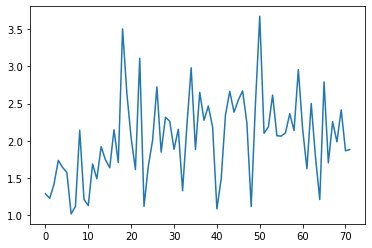

In [10]:
plt.plot(a)

In [10]:
# stats_linear_mixed = data.apply(all_features_statsmod, axis=1)

In [11]:
# stats_linear_mixed_target

In [12]:
# stats_linear_mixed.to_csv('stats_lin_mixed.csv')

In [13]:
# data['stats_linear_mixed'] = stats_linear_mixed

In [14]:
# data['home_stats_3'] = data['stats_linear_mixed'].apply(lambda x: extract(x, 0))
# data['away_stats_3'] = data['stats_linear_mixed'].apply(lambda x: extract(x, 1))
# data['home_stats'] = data['stats_linear_mixed'].apply(lambda x: extract(x, 2))
# data['away_stats'] = data['stats_linear_mixed'].apply(lambda x: extract(x, 3))

In [15]:
data['home_xg_normed'] = data['home_teamStats_xgShot'] - data['mean_ag_away_all_xg']
data['away_xg_normed'] = data['away_teamStats_xgShot'] - data['mean_ag_home_all_xg']

#пытался ввести такую величину, чтоб посмотреть, больше ли команда создала в данном матче,
#чем против соперника в среднем, но вроде толку мало от этого

In [16]:
dick_home_adv = data.groupby('league').xg_diff.mean().to_dict()

dick_home_mean = data.groupby('league').home_teamStats_xgShot.mean().to_dict()
dick_away_mean = data.groupby('league').away_teamStats_xgShot.mean().to_dict()

data['home_ind'] = 1
data['away_ind'] = -1
data['home_adv'] = data['league'].apply(lambda x: dick_home_adv[x])
data['away_adv'] = data['league'].apply(lambda x: dick_home_adv[x]) * -1

data['mean_league_home'] = data['league'].apply(lambda x: dick_home_mean[x])
data['mean_league_away'] = data['league'].apply(lambda x: dick_away_mean[x])

#тут всякие полезные фичи, например, сколько в среднем по лиге голов (голевых моментов) хозяева и гости
#помогает оценить, сколько в среднем в лиге голов и насколько велико преимущество домашнего поля

(array([6.1430e+03, 1.8283e+04, 2.0945e+04, 1.8483e+04, 1.2627e+04,
        7.9500e+03, 4.3160e+03, 2.1510e+03, 1.1190e+03, 5.2000e+02,
        2.1800e+02, 1.0200e+02, 5.9000e+01, 2.0000e+01, 1.0000e+01,
        3.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([0.       , 0.4384392, 0.8768784, 1.3153176, 1.7537568, 2.192196 ,
        2.6306352, 3.0690744, 3.5075136, 3.9459528, 4.384392 , 4.8228312,
        5.2612704, 5.6997096, 6.1381488, 6.576588 , 7.0150272, 7.4534664,
        7.8919056, 8.3303448, 8.768784 ]),
 <a list of 20 Patch objects>)

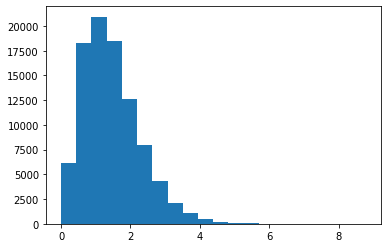

In [17]:
plt.hist(data['home_teamStats_xgShot'], bins=20)

In [18]:
data['home_teamStats_xgShot'].var()

0.682529776851458

In [19]:
data['home_teamStats_goal'].var()

1.5980626851474822

In [20]:
# X = data[['mean_home_3_xg', 'mean_ag_away_3_xg', 'mean_home_all_xg',
#        'mean_ag_away_all_xg', 'mean_home_3_rev_xg', 'mean_ag_away_3_rev_xg',
#        'mean_home_all_rev_xg', 'mean_ag_away_all_rev_xg']]
# y = data['home_teamStats_goal']

In [21]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [22]:
# #здесь че-то обучать пытаюсь

# lr = LinearRegression()#params={"objective": "count:poisson"})
# #lr = XGBRegressor(n_estimators=40)
# lr.fit(X_train, y_train)
# # lr1 = LinearRegression()
# # lr1.fit(X, Y)
# # lr2 = HuberRegressor()
# # lr2.fit(X_train, y_train)
# # lr3 = HuberRegressor()
# # lr3.fit(X, Y)
# y_pred = lr.predict(X_test)
# print(r2_score(y_test, y_pred))
# print(mean_squared_error(y_pred, y_test))
# print(np.abs(y_pred - y_test).mean())
# print('')
# print((y_pred - y_test).mean())
# print('')
# y_diff = y_pred - y_test
# #print(len(y_diff[y_diff < -0.05])/len(y_diff))
# #print(len(y_diff[y_diff > 0.05])/len(y_diff))


In [23]:
odds = pd.read_csv('pinnacle_odds_xg_new.csv')

In [24]:
odds.columns

Index(['Unnamed: 0', 'league', 'home', 'away', 'date', 'p1_open', 'x_open',
       'p2_open', 'hand_open', 'f1_open', 'f2_open', 'total_open', 'over_open',
       'under_open', 'p1_close', 'x_close', 'p2_close', 'hand_close',
       'f1_close', 'f2_close', 'total_close', 'over_close', 'under_close',
       'score', 'date_score', 'date_new', 'ind', 'ind1'],
      dtype='object')

In [25]:
odds1 = odds[['p1_open', 'x_open',
       'p2_open', 'hand_open', 'f1_open', 'f2_open', 'total_open', 'over_open',
       'under_open', 'p1_close', 'x_close', 'p2_close', 'hand_close',
       'f1_close', 'f2_close', 'total_close', 'over_close', 'under_close',
       'score', 'date_score', 'date_new', 'ind1']]

In [26]:
data1 = data.merge(odds1, on='ind1')

#кэфы есть не на все матчи, вот так, поэтому надо сначала запилить фичи по последним играм,
#а потом их прикреплять

#в некст клетках выкидываем лишние матчи, где не хватает данных

In [27]:
data1 = data1[data1['count_home_home'] > 2]
data1 = data1[data1['count_home_away'] > 2]
data1 = data1[data1['count_away_home'] > 2]
data1 = data1[data1['count_away_away'] > 2]

In [28]:
data1 = data1[data1['home_stats_3'] != -999]
data1 = data1[data1['away_stats_3'] != -999]
data1 = data1[data1['home_stats'] != -999]
data1 = data1[data1['away_stats'] != -999]

In [29]:
data1 = data1[data1['home_stats_3'] < 5]
data1 = data1[data1['away_stats_3'] < 5]
data1 = data1[data1['home_stats'] < 5]
data1 = data1[data1['away_stats'] < 5]

In [30]:
#это тоже не смотри особо, пытаюсь пуассона мутить

def value_1(row):
    odd1 = row['f1_open']
    h = np.round(row['hand_open'] * 4)
    probs1 = []
    probs2 = []
    for i in range(0, 20):
        probs1.append(pois(i, row['pred_home']))
        probs2.append(pois(i, row['pred_away']))
    if (h % 2 == 0):
        value = prob_hand(row['hand_open'], probs1, probs2)[0] * odd1
        return value
    elif (h % 4 == 1):
        #print(prob_hand_1(row['hand']))
        value = prob_hand_1(row['hand_open'], probs1, probs2)[0] * odd1 + prob_hand_1(row['hand_open'], probs1, probs2)[1] * ((odd1 - 1) / 2 + 1)
        return value
    else:
        #print(prob_hand_3(row['hand'], probs1, probs2))
        value = prob_hand_3(row['hand_open'], probs1, probs2)[0] * odd1 + prob_hand_3(row['hand_open'], probs1, probs2)[1] * 0.5
        return value
    
def value_2(row):
    odd1 = row['f2_open']
    h = np.round(row['hand_open'] * 4)
    probs1 = []
    probs2 = []
    for i in range(0, 20):
        probs1.append(pois(i, row['pred_home']))
        probs2.append(pois(i, row['pred_away']))
    if (h % 2 == 0):
        value = prob_hand(row['hand_open'], probs1, probs2)[1] * odd1
        return value
    elif (h % 4 == 3):
        value = prob_hand_3(row['hand_open'], probs1, probs2)[2] * odd1 + prob_hand_3(row['hand_open'], probs1, probs2)[1] * ((odd1 - 1) / 2 + 1)
        return value
    else:
        value = prob_hand_1(row['hand_open'], probs1, probs2)[2] * odd1 + prob_hand_1(row['hand_open'], probs1, probs2)[1] * 0.5
        return value

def value_under(row):
    odd1 = row['under_open']
    h = np.round(row['total_open'] * 4)
    probs1 = []
    probs2 = []
    for i in range(0, 20):
        probs1.append(pois(i, row['pred_home']))
        probs2.append(pois(i, row['pred_away']))
    if (h % 2 == 0):
        value = prob_total(row['total_open'], probs1, probs2)[0] * odd1
        return value
    elif (h % 4 == 1):
        #print(prob_hand_1(row['hand']))
        value = prob_total_1(row['total_open'], probs1, probs2)[0] * odd1 + prob_total_1(row['total_open'], probs1, probs2)[1] * ((odd1 - 1) / 2 + 1)
        return value
    else:
        #print(prob_hand_3(row['hand'], probs1, probs2))
        value = prob_total_3(row['total_open'], probs1, probs2)[0] * odd1 + prob_total_3(row['total_open'], probs1, probs2)[1] * 0.5
        return value
    
def value_over(row):
    odd1 = row['over_open']
    h = np.round(row['total_open'] * 4)
    probs1 = []
    probs2 = []
    for i in range(0, 20):
        probs1.append(pois(i, row['pred_home']))
        probs2.append(pois(i, row['pred_away']))
    if (h % 2 == 0):
        value = prob_total(row['total_open'], probs1, probs2)[1] * odd1
        return value
    elif (h % 4 == 3):
        value = prob_total_3(row['total_open'], probs1, probs2)[2] * odd1 + prob_total_3(row['total_open'], probs1, probs2)[1] * ((odd1 - 1) / 2 + 1)
        return value
    else:
        value = prob_total_1(row['total_open'], probs1, probs2)[2] * odd1 + prob_total_1(row['total_open'], probs1, probs2)[1] * 0.5
        return value
    
def prob_total_1(a, probs1=probs1, probs2=probs2): #для +2.25
    normed = 1.0
    win1 = 0.0
    half_win = 0.0
    for i in range (0, 20):
        for j in range (0, 20):
            if (i + j < a - 0.5):
                win1 += probs1[i] * probs2[j]
                #print(i, j, 'under')
            if ((i + j + 0.25) == a):
                half_win += probs1[i] * probs2[j]
                #print(i, j, 'half under')
    return win1, half_win, 1 - win1 - half_win

def prob_total_3(a, probs1=probs1, probs2=probs2): #для 2.75
    normed = 1.0
    win1 = 0.0
    half_lose = 0.0
    for i in range (0, 20):
        for j in range (0, 20):
            if (i + j < a - 0.5):
                win1 += probs1[i] * probs2[j]
            if ((i + j - 0.25) == a):
                half_lose += probs1[i] * probs2[j]
    return win1, half_lose, 1 - win1 - half_lose

In [31]:
data1 = data1[data1['f1_open'] != -999]
data1 = data1[data1['f1_close'] != -999]
data1 = data1[data1['f2_open'] != -999]
data1 = data1[data1['f2_close'] != -999]
data1 = data1[data1['hand_open'] != -999]
data1 = data1[data1['hand_close'] != -999]

data1 = data1[data1['over_open'] != -999]
data1 = data1[data1['over_close'] != -999]
data1 = data1[data1['under_open'] != -999]
data1 = data1[data1['under_close'] != -999]
data1 = data1[data1['total_open'] != -999]
data1 = data1[data1['total_close'] != -999]

In [32]:
data1['pred_bk_home'] = data1.apply(pred_home_bk, axis=1)
data1['pred_bk_away'] = data1.apply(pred_away_bk, axis=1)

#это я пытаюсь оценить, сколько голов предсказывает бк каждой из команд, функция в самом начале

In [33]:
data1

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,index,league,home,away,country,season,match_competitionFormat,...,f1_close,f2_close,total_close,over_close,under_close,score,date_score,date_new,pred_bk_home,pred_bk_away
0,15134,15134,55997,15134,Brazil. Serie A,FlamengoBRA,América MineiroBRA,BRA,2016,domestic_league,...,1.833,2.090,2.50,1.862,2.040,NaN,2016-07-26 02:00,2016-07-26,2.019400,0.672867
16,15151,15151,62084,15151,China PR. CSL,Beijing GuoanCHN,Zhejiang GreentownCHN,CHN,2016,domestic_league,...,1.769,2.120,2.50,1.869,2.010,NaN,2016-07-29 14:35,2016-07-29,1.909124,0.701791
18,15154,15154,24357,15154,Norway. Eliteserien,Sarpsborg 08NOR,StartNOR,NOR,2016,domestic_league,...,2.040,1.877,3.00,1.917,1.980,NaN,2016-07-29 20:00,2016-07-29,2.176413,0.891747
28,15165,15165,91723,15165,Peru. Primera División,Comerciantes UnidosPER,Unión ComercioPER,PER,2016,domestic_league,...,1.925,1.917,2.50,1.833,2.010,NaN,2016-07-29 23:30,2016-07-29,1.722733,0.909800
35,15172,15172,15576,15172,Japan. J1 League,Yokohama F. MarinosJPN,Nagoya GrampusJPN,JPN,2016,domestic_league,...,1.892,2.030,2.75,1.892,2.010,NaN,2016-07-30 13:00,2016-07-30,1.857311,0.934511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56282,92946,92946,9704,92946,Italy. Serie A,BolognaITA,FiorentinaITA,ITA,2019/2020,domestic_league,...,1.925,1.990,2.50,1.877,2.020,1:1,2020-01-06 14:30 1:1,2020-01-06,1.468444,1.351111
56283,92947,92947,8955,92947,Italy. Serie A,AtalantaITA,ParmaITA,ITA,2019/2020,domestic_league,...,2.020,1.892,3.50,2.050,1.854,5:0,2020-01-06 17:00 5:0,2020-01-06,2.335720,0.968387
56284,92948,92948,8802,92948,Italy. Serie A,JuventusITA,CagliariITA,ITA,2019/2020,domestic_league,...,2.060,1.854,3.25,1.980,1.917,4:0,2020-01-06 17:00 4:0,2020-01-06,2.421609,0.868276
56285,92949,92949,7502,92949,Israel. Ligat ha'Al,Maccabi HaifaISR,Maccabi Tel AvivISR,ISR,2019/2020,domestic_league,...,1.900,1.980,2.25,1.925,1.934,3:4,2020-01-06 21:15 3:4,2020-01-06,1.227218,1.286418


In [34]:
# cols_home = ['mean_home_3_xg', 'mean_ag_away_3_xg', 'mean_home_all_xg',
#        'mean_ag_away_all_xg', 'mean_home_3_rev_xg', 'mean_ag_away_3_rev_xg',
#        'mean_home_all_rev_xg', 'mean_ag_away_all_rev_xg', 
#              'home_stats', 'home_stats_3',
#              'count_home', 'home_adv',
#             'mean_league_home', 'home_teamStats_xgShot', 'home_teamStats_goal']

# cols_away = ['mean_away_3_xg', 'mean_ag_home_3_xg', 'mean_away_all_xg', 'mean_ag_home_all_xg',
#        'mean_away_3_rev_xg', 'mean_ag_home_3_rev_xg', 'mean_away_all_rev_xg',
#        'mean_ag_home_all_rev_xg',
#              'away_stats', 'away_stats_3',
#              'count_away', 'away_adv',
#             'mean_league_away', 'away_teamStats_xgShot', 'away_teamStats_goal']



In [35]:
# data_home = data1[cols_home]
# data_away = data1[cols_away]

In [36]:
# X_home = data_home.drop(['home_teamStats_xgShot', 'home_teamStats_goal'], axis=1)
# y_home = data_home['home_teamStats_goal']

# X_away = data_away.drop(['away_teamStats_xgShot', 'away_teamStats_goal'], axis=1)
# y_away = data_away['away_teamStats_goal']




In [37]:
# arr_pred = np.zeros([4, 4])
# arr_real = np.zeros([4, 4])
# for count in range(0, 100):
#     data_home = data1[cols_home]
#     data_away = data1[cols_away]
    
#     if (count % 1 == 0):
#         print(count)
#     a = np.arange(int(len(data1)))

#     np.random.shuffle(a)

#     nums = a[int(len(X_home) / 5):]
#     nums1 = a[:int(len(X_home) / 5)]

#     #Mlen(nums)

#     X_home_train = X_home.iloc[nums]
#     y_home_train = y_home.iloc[nums]

#     X_away_train = X_away.iloc[nums]
#     y_away_train = y_away.iloc[nums]

#     lr_home = LinearRegression()
#     lr_away = LinearRegression()

#     lr_home.fit(X_home_train, y_home_train)
#     lr_away.fit(X_away_train, y_away_train)

#     data_test = data1.iloc[nums1]
#     print(len(data_test))

    


#     home_test = data_test[cols_home]

#     away_test = data_test[cols_away]

#     home_test = home_test.drop(['home_teamStats_xgShot', 'home_teamStats_goal'], axis=1)
#     away_test = away_test.drop(['away_teamStats_xgShot', 'away_teamStats_goal'], axis=1)

#     # away_test.head()

#     # away_test.mean_ag_home_3_xg.mean()

#     pred_home = lr_home.predict(home_test)
#     pred_away = lr_away.predict(away_test)

#     # pred_home.mean()

#     data_test['pred_home'] = pred_home
#     data_test['pred_away'] = pred_away
#     for i in range(0, 4):
#         for j in range(0, 4):
#             #print(i, '-', j, sep='')
#             ww = data_test.apply(lambda x: count_score(x, i, j), axis=1)
#             arr_pred[i][j] += (ww.mean())
#             arr_real[i][j] += (len(data_test[np.logical_and(data_test['home_teamStats_goal'] == i, data_test['away_teamStats_goal'] == j)]) / len(data_test))
        

In [38]:
# arr_pred

In [39]:
# arr_real

In [40]:
# (arr_pred/100) * 

In [41]:
# (arr_real/100)

In [42]:
# (arr_pred/100) - (arr_real/100)

In [43]:
# def count_1_0(row):
#     probs1 = []
#     probs2 = []
#     for i in range(0, 20):
#         probs1.append(pois(i, row['pred_home']))
#         probs2.append(pois(i, row['pred_away']))
#     return probs1[1] * probs2[0]

# def count_0_1(row):
#     probs1 = []
#     probs2 = []
#     for i in range(0, 20):
#         probs1.append(pois(i, row['pred_home']))
#         probs2.append(pois(i, row['pred_away']))
#     return probs1[0] * probs2[1]

# def count_0_0(row):
#     probs1 = []
#     probs2 = []
#     for i in range(0, 20):
#         probs1.append(pois(i, row['pred_home']))
#         probs2.append(pois(i, row['pred_away']))
#     return probs1[0] * probs2[0]

# def count_1_1(row):
#     probs1 = []
#     probs2 = []
#     for i in range(0, 20):
#         probs1.append(pois(i, row['pred_home']))
#         probs2.append(pois(i, row['pred_away']))
#     return probs1[1] * probs2[1]

In [44]:
# def count_score(row, a, b):
#     probs1 = []
#     probs2 = []
#     for i in range(0, 20):
#         probs1.append(pois(i, row['pred_home']))
#         probs2.append(pois(i, row['pred_away']))
#     return probs1[a] * probs2[b]

In [45]:
# data_test.apply(count_1_0, axis=1)

In [46]:
# for i in range(0, 4):
#     for j in range(0, 4):
#         print(i, '-', j, sep='')
#         ww = data_test.apply(lambda x: count_score(x, i, j), axis=1)
#         print('pred', ww.mean())
#         print('real', len(data_test[np.logical_and(data_test['home_teamStats_goal'] == i, data_test['away_teamStats_goal'] == j)]) / len(data_test))
        

## ВСЕ дальше уже мои эксперименты, дальше можешь не смотреть

In [47]:
# data1['mean_home_3_touches_agg'] = (data1['mean_home_3_touches'] + data1['mean_home_3_rev_touches'])/2
# data1['mean_away_3_touches_agg'] = (data1['mean_away_3_touches'] + data1['mean_away_3_rev_touches'])/2

# data1['mean_ag_home_3_touches_agg'] = (data1['mean_ag_home_3_touches'] + data1['mean_ag_home_3_rev_touches'])/2
# data1['mean_ag_away_3_touches_agg'] = (data1['mean_ag_away_3_touches'] + data1['mean_ag_away_3_rev_touches'])/2



In [48]:
# X = data1[['mean_home_3_xg', 'mean_ag_away_3_xg', 'mean_home_all_xg',
#        'mean_ag_away_all_xg', 'mean_home_3_rev_xg', 'mean_ag_away_3_rev_xg',
#        'mean_home_all_rev_xg', 'mean_ag_away_all_rev_xg']]
# y = data1['home_teamStats_goal']

In [49]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [50]:
len(data1)

43523

In [51]:
coef_lin_comb = 0.3 

In [52]:
data1['new_goal_home'] = (1 + coef_lin_comb) * data1['home_teamStats_goal'] - coef_lin_comb * data1['pred_bk_home']
data1['new_goal_away'] = (1 + coef_lin_comb) * data1['away_teamStats_goal'] - coef_lin_comb * data1['pred_bk_away']

#есть мысль предсказывать не целевую переменную, а типа предсказывать в другую сторону от оценки БК
#допустим цель 2, а бк оценила 1, тогда предсказываем 2.3, чтоб наша оценка сильнее отличалась от БК в нужную сторону и было больше ставок
#но ценность этой эвристики пока не подтверждена

In [53]:
data1['new_goal_away'].mean()

1.144329316453372

In [54]:
#это типа фичи нужные
cols_home = ['mean_home_3_xg', 'mean_ag_away_3_xg', 'mean_home_all_xg',
       'mean_ag_away_all_xg', 'mean_home_3_rev_xg', 'mean_ag_away_3_rev_xg',
       'mean_home_all_rev_xg', 'mean_ag_away_all_rev_xg', 
             'home_stats', 'home_stats_3',
             'count_home', 'home_adv',
            'mean_league_home', 'home_teamStats_xgShot', 'home_teamStats_goal', 'new_goal_home']

cols_away = ['mean_away_3_xg', 'mean_ag_home_3_xg', 'mean_away_all_xg', 'mean_ag_home_all_xg',
       'mean_away_3_rev_xg', 'mean_ag_home_3_rev_xg', 'mean_away_all_rev_xg',
       'mean_ag_home_all_rev_xg',
             'away_stats', 'away_stats_3',
             'count_away', 'away_adv',
            'mean_league_away', 'away_teamStats_xgShot', 'away_teamStats_goal', 'new_goal_away']


In [55]:
# cols_home = ['mean_home_3_target', 'mean_ag_away_3_target', 'mean_home_all_target',
#        'mean_ag_away_all_target', 'mean_home_3_rev_target', 'mean_ag_away_3_rev_target',
#        'mean_home_all_rev_target', 'mean_ag_away_all_rev_target', 
#              'count_home', 'home_adv',
#             'mean_league_home', 'home_teamStats_xgShot', 'home_teamStats_goal', 'new_goal_home']

# cols_away = ['mean_away_3_target', 'mean_ag_home_3_target', 'mean_away_all_target', 'mean_ag_home_all_target',
#        'mean_away_3_rev_target', 'mean_ag_home_3_rev_target', 'mean_away_all_rev_target',
#        'mean_ag_home_all_rev_target',
#              'count_away', 'away_adv',
#             'mean_league_away', 'away_teamStats_xgShot', 'away_teamStats_goal', 'new_goal_away']

 


In [56]:
data.columns[:64]

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'index', 'league',
       'home', 'away', 'country', 'season', 'match_competitionFormat',
       'match_competitionId', 'date', 'match_duration', 'match_id',
       'match_name', 'match_roundName', 'match_score', 'match_seasonId',
       'match_teamA', 'match_teamAId', 'match_teamB', 'match_teamBId',
       'source', 'home_teamStats_averageShotDistance',
       'home_teamStats_shotSuccess', 'home_teamStats_deepCompletedPassSuccess',
       'home_teamStats_positionalAttacksWithShot', 'home_teamStats_shot',
       'home_teamStats_touchInBoxSuccess',
       'home_teamStats_passToPenaltyAreaSuccess', 'home_teamStats_goal',
       'home_teamStats_xgShot', 'home_teamStats_corner', 'ind_home', 'index.1',
       'away_teamStats_averageShotDistance', 'away_teamStats_shotSuccess',
       'away_teamStats_deepCompletedPassSuccess',
       'away_teamStats_positionalAttacksWithShot', 'away_teamStats_shot',
       'away_teamStats_touchInBoxSucces

In [57]:
# pd.DataFrame(sorted(data['league'].unique())).to_excel('villi.xlsx')

In [58]:
top_leagues = ['Argentina. Superliga', 'England. Premier League', 'Spain. Primera División',
              'England. Championship', 'France. Ligue', 'Netherlands. Eredivisie',
              'Portugal. Primeira Liga', 'Italy. Serie A', 'Germany. Bundesliga', 'Russia. Premier League',
              'Turkey. 1. Lig', 'Belgium. First Division A', 'Brazil. Serie A',
              'Denmark. Superliga', 'Switzerland. Super League']

#выкидываем топ лиги, т.к там обычно лучше оценка БК, хотя для обучения их можно оставить

In [59]:
#sorted(data['league'].unique())

In [60]:
# template = ['mean_home_3_', 'mean_ag_away_3_', 'mean_home_all_', 'mean_ag_away_all_',
#                     'mean_home_3_rev_', 'mean_ag_away_3_rev_', 'mean_home_all_rev_', 'mean_ag_away_all_rev_',
#                     'mean_away_3_', 'mean_ag_home_3_', 'mean_away_all_', 'mean_ag_home_all_',
#                     'mean_away_3_rev_', 'mean_ag_home_3_rev_', 'mean_away_all_rev_', 'mean_ag_home_all_rev_']


# stats = ['xg', 'touches', 'dist', 'target', 'shot', 'passes']

# cols_home_xg = ['home_teamStats_xgShot']
# cols_away_xg = ['away_teamStats_xgShot']

# cols_home_touches = ['home_teamStats_touchInBoxSuccess']
# cols_away_touches = ['away_teamStats_touchInBoxSuccess']

# cols_home_dist = ['home_teamStats_averageShotDistance']
# cols_away_dist = ['away_teamStats_averageShotDistance']

# cols_home_target = ['home_teamStats_shotSuccess']
# cols_away_target = ['away_teamStats_shotSuccess']

# cols_home_shot = ['home_teamStats_shot']
# cols_away_shot = ['away_teamStats_shot']

# cols_home_passes = ['home_teamStats_passToPenaltyAreaSuccess']
# cols_away_passes = ['away_teamStats_passToPenaltyAreaSuccess']


In [61]:
# sett = [cols_home_xg, cols_away_xg, cols_home_touches, cols_away_touches, 
#         cols_home_dist, cols_away_dist, cols_home_target, cols_away_target,
#         cols_home_shot, cols_away_shot, cols_home_passes, cols_away_passes]

In [62]:
# for i in range (0, 12, 2):
#     #names = []
#     for j in range(0, 8):
#         sett[i].append(template[j] + stats[i//2])
#     for j in range(8, 16):
#         sett[i+1].append(template[j] + stats[i//2])

In [63]:
# cols_away_shot

In [64]:
# cols_home = ['mean_home_all_xg',
#        'mean_ag_away_all_xg',
#        'mean_home_all_rev_xg', 'mean_ag_away_all_rev_xg', 'count_home', 'home_adv',
#             'mean_league_home', 'home_teamStats_xgShot', 'home_teamStats_goal',
#              'mean_home_3_touches_agg',
#        'mean_ag_away_3_touches_agg', 'mean_home_all_touches',
#        'mean_ag_away_all_touches',
#        'mean_home_all_rev_touches',
#        'mean_ag_away_all_rev_touches', 'new_goal_home'
#             ]

# cols_away = ['mean_away_all_xg', 'mean_ag_home_all_xg',
#        'mean_away_all_rev_xg',
#        'mean_ag_home_all_rev_xg', 'count_away', 'away_adv',
#             'mean_league_away', 'away_teamStats_xgShot', 'away_teamStats_goal',
#             'mean_away_3_touches_agg',
#        'mean_ag_home_3_touches_agg', 'mean_away_all_touches',
#        'mean_ag_home_all_touches', 'mean_away_all_rev_touches',
#        'mean_ag_home_all_rev_touches', 'new_goal_away']

In [65]:
data_cop = data1.copy()

In [66]:
data1 = data_cop.copy()

In [67]:
#data1[~data1['league'].isin(top_leagues)]

In [68]:
data1 = data1[~data1['league'].isin(top_leagues)]

In [69]:
data_home = data1[cols_home]
data_away = data1[cols_away]

In [70]:
# X_home = data_home.drop(['home_teamStats_xgShot', 'home_teamStats_goal', 'new_goal_home'], axis=1)
# y_home = data_home['new_goal_home']

# X_away = data_away.drop(['away_teamStats_xgShot', 'away_teamStats_goal', 'new_goal_away'], axis=1)
# y_away = data_away['new_goal_away']


In [71]:
X_home = data_home.drop(['home_teamStats_xgShot', 'home_teamStats_goal', 'new_goal_home'], axis=1)
y_home = data_home['home_teamStats_goal']

X_away = data_away.drop(['away_teamStats_xgShot', 'away_teamStats_goal', 'new_goal_away'], axis=1)
y_away = data_away['away_teamStats_goal']



In [72]:
# preds_cols_home = []
# preds_cols_away = []
# for i in range(0, 6):
#     preds_cols_home.append('pred_home_' + stats[i])
#     preds_cols_away.append('pred_away_' + stats[i])

In [73]:
# home_cols = ['home_teamStats_xgShot',
#             'home_teamStats_touchInBoxSuccess',
#              'home_teamStats_averageShotDistance', 'home_teamStats_shotSuccess',
#        'home_teamStats_shot',
#        'home_teamStats_passToPenaltyAreaSuccess', 'home_teamStats_goal']

# away_cols = ['away_teamStats_xgShot',
#             'away_teamStats_touchInBoxSuccess',
#              'away_teamStats_averageShotDistance', 'away_teamStats_shotSuccess',
#        'away_teamStats_shot',
#        'away_teamStats_passToPenaltyAreaSuccess', 'away_teamStats_goal']

In [74]:
import warnings
warnings.filterwarnings("ignore")

In [75]:
data1

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,index,league,home,away,country,season,match_competitionFormat,...,total_close,over_close,under_close,score,date_score,date_new,pred_bk_home,pred_bk_away,new_goal_home,new_goal_away
16,15151,15151,62084,15151,China PR. CSL,Beijing GuoanCHN,Zhejiang GreentownCHN,CHN,2016,domestic_league,...,2.50,1.869,2.010,NaN,2016-07-29 14:35,2016-07-29,1.909124,0.701791,0.727263,-0.210537
18,15154,15154,24357,15154,Norway. Eliteserien,Sarpsborg 08NOR,StartNOR,NOR,2016,domestic_league,...,3.00,1.917,1.980,NaN,2016-07-29 20:00,2016-07-29,2.176413,0.891747,0.647076,-0.267524
28,15165,15165,91723,15165,Peru. Primera División,Comerciantes UnidosPER,Unión ComercioPER,PER,2016,domestic_league,...,2.50,1.833,2.010,NaN,2016-07-29 23:30,2016-07-29,1.722733,0.909800,-0.516820,-0.272940
35,15172,15172,15576,15172,Japan. J1 League,Yokohama F. MarinosJPN,Nagoya GrampusJPN,JPN,2016,domestic_league,...,2.75,1.892,2.010,NaN,2016-07-30 13:00,2016-07-30,1.857311,0.934511,-0.557193,-0.280353
38,15175,15175,18952,15175,Korea Republic. K League 1,SuwonKOR,Sangju SangmuKOR,KOR,2016,domestic_league,...,2.75,1.917,1.980,NaN,2016-07-30 13:00,2016-07-30,1.368547,1.554547,-0.410564,2.133636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56273,92935,92935,28773,92935,Portugal. Segunda Liga,FarensePRT,Benfica IIPRT,PRT,2019/2020,domestic_league,...,2.50,1.943,1.925,0:3,2020-01-05 14:15 0:3,2020-01-05,1.839982,0.919982,-0.551995,3.624005
56274,92936,92936,50367,92936,Cyprus. 1. Division,Nea SalamisCYP,Ethnikos AchnasCYP,CYP,2019/2020,domestic_league,...,2.75,1.819,2.010,3:2,2020-01-05 20:00 3:2,2020-01-05,1.726200,1.059933,3.382140,2.282020
56277,92939,92939,57671,92939,Egypt. Premier League,Al AhlyEGY,MasrEGY,EGY,2019/2020,domestic_league,...,2.50,1.847,2.010,3:1,2020-01-05 20:30 3:1,2020-01-05,2.282467,0.469533,3.215260,1.159140
56280,92944,92944,58084,92944,Qatar. QNB Stars League,Al ArabiQAT,Al SaddQAT,QAT,2019/2020,domestic_league,...,3.75,1.862,1.970,1:6,2020-01-06 18:45 1:6,2020-01-06,1.288604,2.412871,0.913419,7.076139


In [ ]:
all_profit = []
all_roi = []
# all_profit_120 = []
# all_roi_120 = []
# all_profit_125 = []
# all_roi_125 = []
# all_profit_130 = []
# all_roi_130 = []
for count in range(0, 10):
    print(count)
    
    data_home = data1[cols_home]
    data_away = data1[cols_away]
    
#     if (count % 1 == 0):
#         print(count)
    a = np.arange(int(len(data1)))

    np.random.shuffle(a)

    nums = a[int(len(X_home) / 5):] #train
    nums_valid = a[int(len(X_home) / 10):int(len(X_home) / 5) + int(len(X_home) / 10)] #valid
    #nums_valid = nums
    nums_test = a[:int(len(X_home) / 10)] #test
    
    #print(nums_valid)
    #Mlen(nums)

    X_home_train = X_home.iloc[nums]
    y_home_train = y_home.iloc[nums]

    X_away_train = X_away.iloc[nums]
    y_away_train = y_away.iloc[nums]

    lr_home = LinearRegression()
    lr_away = LinearRegression()

    lr_home.fit(X_home_train, y_home_train)
    lr_away.fit(X_away_train, y_away_train)

    data_valid = data1.iloc[nums_valid]
    #print(len(data_valid))

    


    home_valid = data_valid[cols_home]

    away_valid = data_valid[cols_away]

    home_valid = home_valid.drop(['home_teamStats_xgShot', 'home_teamStats_goal', 'new_goal_home'], axis=1)
    away_valid = away_valid.drop(['away_teamStats_xgShot', 'away_teamStats_goal', 'new_goal_away'], axis=1)

    # away_test.head()

    # away_test.mean_ag_home_3_xg.mean()

    pred_home = lr_home.predict(home_valid)
    pred_away = lr_away.predict(away_valid)

    # pred_home.mean()

    data_valid['pred_home'] = pred_home
    data_valid['pred_away'] = pred_away

    # data1.columns[-30:]



    data_valid['value_1'] = data_valid.apply(value_1, axis=1)
    data_valid['value_2'] = data_valid.apply(value_2, axis=1)

    data_valid_1 = data_valid[:10]

    data_valid['value_over'] = data_valid.apply(value_over, axis=1)
    data_valid['value_under'] = data_valid.apply(value_under, axis=1)

    # data_test[['over_open', 'under_open', 'total_open', 'pred_home', 'pred_away', 'value_over', 'value_under']]
    #print(data_valid)

    #threshold_hand = 1.2
    threshold_hand = 1
    
    #threshold_total = 1.15
    threshold_total = 1

    def equal(a, b):
        if (np.abs(a - b) < 0.01):
            return True
        else:
            return False
    


    profit = []
    types = []
#     profit_120 = []
#     profit_125 = []
#     profit_130 = []
    for i, row in data_valid.iterrows():
        if (row['value_1'] > threshold_hand):
            if (equal(row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'], 0)):
                profit.append(0)
                types.append('f1')
            if (equal(row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'], 0.25)):
                profit.append((row['f1_open'] - 1) / 2)
                types.append('f1')
            if (equal(row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'], -0.25)):
                profit.append(-0.5)
                types.append('f1')
            if (row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'] < -0.4):
                profit.append(-1)
                types.append('f1')
            if (row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'] > 0.4):
                profit.append(row['f1_open'] - 1)
                types.append('f1')
#             if (row['value_1'] > 1.25):
#                 profit_120.append(profit[-1])
#             if (row['value_1'] > 1.30):
#                 profit_125.append(profit[-1])
#             if (row['value_1'] > 1.35):
#                 profit_130.append(profit[-1])
                
        if (row['value_2'] > threshold_hand):
            if (equal(row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'], 0)):
                profit.append(0)
                types.append('f2')
            if (equal(row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'], -0.25)):
                profit.append((row['f2_open'] - 1) / 2)
                types.append('f2')
            if (equal(row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'], 0.25)):
                profit.append(-0.5)
                types.append('f2')
            if (row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'] < -0.4):
                profit.append(row['f2_open'] - 1)
                types.append('f2')
            if (row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'] > 0.4):
                profit.append(-1)
                types.append('f2')
#             if (row['value_2'] > 1.25):
#                 profit_120.append(profit[-1])
#             if (row['value_2'] > 1.30):
#                 profit_125.append(profit[-1])
#             if (row['value_2'] > 1.35):
#                 profit_130.append(profit[-1])

        if (row['value_over'] > threshold_total):
            if (equal(row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'], 0)):
                profit.append(0)
                types.append('over')
            if (equal(row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'], 0.25)):
                profit.append((row['over_open'] - 1) / 2)
                types.append('over')
            if (equal(row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'], -0.25)):
                profit.append(-0.5)
                types.append('over')
            if (row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'] < -0.4):
                profit.append(-1)
                types.append('over')
            if (row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'] > 0.4):
                profit.append(row['over_open'] - 1)
                types.append('over')
#             if (row['value_over'] > 1.20):
#                 profit_120.append(profit[-1])
#             if (row['value_over'] > 1.25):
#                 profit_125.append(profit[-1])
#             if (row['value_over'] > 1.30):
#                 profit_130.append(profit[-1])
                
        if (row['value_under'] > threshold_total):
            if (equal(row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'], 0)):
                profit.append(0)
                types.append('under')
            if (equal(row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'], -0.25)):
                profit.append((row['under_open'] - 1) / 2)
                types.append('under')
            if (equal(row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'], 0.25)):
                profit.append(-0.5)
                types.append('under')
            if (row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'] < -0.4):
                profit.append(row['under_open'] - 1)
                types.append('under')
            if (row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'] > 0.4):
                profit.append(-1)
                types.append('under')
#             if (row['value_under'] > 1.20):
#                 profit_120.append(profit[-1])
#             if (row['value_under'] > 1.25):
#                 profit_125.append(profit[-1])
#             if (row['value_under'] > 1.30):
#                 profit_130.append(profit[-1])

    pr = np.array(profit).sum()
    roi = np.array(profit).mean()
#     pr_120 = np.array(profit_120).sum()
#     roi_120 = np.array(profit_120).mean()
#     pr_125 = np.array(profit_125).sum()
#     roi_125 = np.array(profit_125).mean()
#     pr_130 = np.array(profit_130).sum()
#     roi_130 = np.array(profit_130).mean()
#     all_profit.append(pr)
#     all_roi.append(roi)
#     all_profit_120.append(pr_120)
#     all_roi_120.append(roi_120)
#     all_profit_125.append(pr_125)
#     all_roi_125.append(roi_125)
#     all_profit_130.append(pr_130)
#     all_roi_130.append(roi_130)
    threshold_hand1 = []
    threshold_hand2 = []
    threshold_total_over = []
    threshold_total_under = []
    ###########
    dff = pd.DataFrame({'profit':profit, 'types':types})
    dff = dff[dff['types'] == 'f1']
    dff['value_1'] = data_valid[data_valid['value_1'] > 1].value_1.values
    dff_1, dff_2 = train_test_split(dff, test_size=0.5)
    dff_3, dff_4 = train_test_split(dff, test_size=0.5)
    dff_5, dff_6 = train_test_split(dff, test_size=0.5)
    dff_7, dff_8 = train_test_split(dff, test_size=0.5)
    dff_9, dff_10 = train_test_split(dff, test_size=0.5)
    
    for x in [dff_1, dff_2, dff_3, dff_4, dff_5, dff_6, dff_7, dff_8, dff_9, dff_10]:
        x = x.sort_values(by = 'value_1', ascending=0)
        x['res'] = x.profit.cumsum()
        threshold_hand1.append(x[x['res'] == x['res'].max()].iloc[0].value_1)
    threshold_hand1_max = np.array(threshold_hand1).max()
    ###########
    dff = pd.DataFrame({'profit':profit, 'types':types})
    dff = dff[dff['types'] == 'f2']
    dff['value_2'] = data_valid[data_valid['value_2'] > 1].value_2.values
    dff_1, dff_2 = train_test_split(dff, test_size=0.5)
    dff_3, dff_4 = train_test_split(dff, test_size=0.5)
    dff_5, dff_6 = train_test_split(dff, test_size=0.5)
    dff_7, dff_8 = train_test_split(dff, test_size=0.5)
    dff_9, dff_10 = train_test_split(dff, test_size=0.5)
    
    for x in [dff_1, dff_2, dff_3, dff_4, dff_5, dff_6, dff_7, dff_8, dff_9, dff_10]:
        x = x.sort_values(by = 'value_2', ascending=0)
        x['res'] = x.profit.cumsum()
        threshold_hand2.append(x[x['res'] == x['res'].max()].iloc[0].value_2)
    threshold_hand2_max = np.array(threshold_hand2).max()
    ###########
    dff = pd.DataFrame({'profit':profit, 'types':types})
    dff = dff[dff['types'] == 'over']
    dff['value_over'] = data_valid[data_valid['value_over'] > 1].value_over.values
    dff_1, dff_2 = train_test_split(dff, test_size=0.5)
    dff_3, dff_4 = train_test_split(dff, test_size=0.5)
    dff_5, dff_6 = train_test_split(dff, test_size=0.5)
    dff_7, dff_8 = train_test_split(dff, test_size=0.5)
    dff_9, dff_10 = train_test_split(dff, test_size=0.5)
    
    for x in [dff_1, dff_2, dff_3, dff_4, dff_5, dff_6, dff_7, dff_8, dff_9, dff_10]:
        x = x.sort_values(by = 'value_over', ascending=0)
        x['res'] = x.profit.cumsum()
        threshold_total_over.append(x[x['res'] == x['res'].max()].iloc[0].value_over)
    threshold_total_over_max = np.array(threshold_total_over).max()
    ###########
    dff = pd.DataFrame({'profit':profit, 'types':types})
    dff = dff[dff['types'] == 'under']
    dff['value_under'] = data_valid[data_valid['value_under'] > 1].value_under.values
    dff_1, dff_2 = train_test_split(dff, test_size=0.5)
    dff_3, dff_4 = train_test_split(dff, test_size=0.5)
    dff_5, dff_6 = train_test_split(dff, test_size=0.5)
    dff_7, dff_8 = train_test_split(dff, test_size=0.5)
    dff_9, dff_10 = train_test_split(dff, test_size=0.5)
    
    for x in [dff_1, dff_2, dff_3, dff_4, dff_5, dff_6, dff_7, dff_8, dff_9, dff_10]:
        x = x.sort_values(by = 'value_under', ascending=0)
        x['res'] = x.profit.cumsum()
        threshold_total_under.append(x[x['res'] == x['res'].max()].iloc[0].value_under)
    threshold_total_under_max =  np.array(threshold_total_under).max()
    ###########
    #
    #
    #
    #
    #Test
    ###########
    data_test = data1.iloc[nums_test]
    #print(len(data_valid))

    


    home_test = data_test[cols_home]

    away_test = data_test[cols_away]

    home_test = home_test.drop(['home_teamStats_xgShot', 'home_teamStats_goal', 'new_goal_home'], axis=1)
    away_test = away_test.drop(['away_teamStats_xgShot', 'away_teamStats_goal', 'new_goal_away'], axis=1)

    # away_test.head()

    # away_test.mean_ag_home_3_xg.mean()

    pred_home = lr_home.predict(home_test)
    pred_away = lr_away.predict(away_test)

    # pred_home.mean()

    data_test['pred_home'] = pred_home
    data_test['pred_away'] = pred_away

    # data1.columns[-30:]



    data_test['value_1'] = data_test.apply(value_1, axis=1)
    data_test['value_2'] = data_test.apply(value_2, axis=1)

    data_test_1 = data_test[:10]

    data_test['value_over'] = data_test.apply(value_over, axis=1)
    data_test['value_under'] = data_test.apply(value_under, axis=1)

    


    profit = []
    types = []
    for i, row in data_test.iterrows():
        if (row['value_1'] > threshold_hand1_mean):
            if (equal(row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'], 0)):
                profit.append(0)
                types.append('f1')
            if (equal(row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'], 0.25)):
                profit.append((row['f1_open'] - 1) / 2)
                types.append('f1')
            if (equal(row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'], -0.25)):
                profit.append(-0.5)
                types.append('f1')
            if (row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'] < -0.4):
                profit.append(-1)
                types.append('f1')
            if (row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'] > 0.4):
                profit.append(row['f1_open'] - 1)
                types.append('f1')

                
        if (row['value_2'] > threshold_hand2_mean):
            if (equal(row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'], 0)):
                profit.append(0)
                types.append('f2')
            if (equal(row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'], -0.25)):
                profit.append((row['f2_open'] - 1) / 2)
                types.append('f2')
            if (equal(row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'], 0.25)):
                profit.append(-0.5)
                types.append('f2')
            if (row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'] < -0.4):
                profit.append(row['f2_open'] - 1)
                types.append('f2')
            if (row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'] > 0.4):
                profit.append(-1)
                types.append('f2')


        if (row['value_over'] > threshold_total_over_mean):
            if (equal(row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'], 0)):
                profit.append(0)
                types.append('over')
            if (equal(row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'], 0.25)):
                profit.append((row['over_open'] - 1) / 2)
                types.append('over')
            if (equal(row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'], -0.25)):
                profit.append(-0.5)
                types.append('over')
            if (row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'] < -0.4):
                profit.append(-1)
                types.append('over')
            if (row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'] > 0.4):
                profit.append(row['over_open'] - 1)
                types.append('over')

                
        if (row['value_under'] > threshold_total_under_mean):
            if (equal(row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'], 0)):
                profit.append(0)
                types.append('under')
            if (equal(row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'], -0.25)):
                profit.append((row['under_open'] - 1) / 2)
                types.append('under')
            if (equal(row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'], 0.25)):
                profit.append(-0.5)
                types.append('under')
            if (row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'] < -0.4):
                profit.append(row['under_open'] - 1)
                types.append('under')
            if (row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'] > 0.4):
                profit.append(-1)
                types.append('under')


    pr = np.array(profit).sum()
    roi = np.array(profit).mean()
    all_profit.append(pr)
    all_roi.append(roi)
    


0
1


In [188]:
print(np.array(all_profit).mean()) #val = train, treshhold = max, train = 0.2
print(np.array(all_roi).mean())

117.33579999999992
0.026457713532157527


In [177]:
print(np.array(all_profit).mean()) #treshhold = mean
print(np.array(all_roi).mean())

35.731799999999964
0.0141104868490763


In [190]:
print(np.array(all_profit).mean()) #treshhold = max, test valid intersect??
print(np.array(all_roi).mean())

115.66424999999995
0.025983765073364206


In [ ]:
print(np.array(all_profit).mean()) #treshhold = max
print(np.array(all_roi).mean())

In [158]:
dff = pd.DataFrame({'profit':profit, 'types':types})

In [159]:
dff = dff[dff['types'] == 'f1']

In [160]:
dff['value_1'] = data_valid[data_valid['value_1'] > 1].value_1.values

In [161]:
dff_1, dff_2 = train_test_split(dff, test_size=0.5)
dff_3, dff_4 = train_test_split(dff, test_size=0.5)
dff_5, dff_6 = train_test_split(dff, test_size=0.5)

In [166]:
thresholds = []
for x in [dff_1, dff_2, dff_3, dff_4, dff_5, dff_6]:
    x = x.sort_values(by = 'value_1', ascending=0)
    x['res'] = x.profit.cumsum()
    thresholds.append(x[x['res'] == x['res'].max()].iloc[0].value_1)

In [167]:
np.array(thresholds).mean()


1.1852405213368595

In [127]:
dff['res'] = dff.profit.cumsum()

In [157]:
dff

,profit,types,value_1,res
0,1.010,f1,1.044504,0
2,0.909,f1,1.056660,0
6,0.000,f1,1.053842,0
8,1.020,f1,1.095606,0
13,-1.000,f1,1.453764,0
...,...,...,...,...
10968,-1.000,f1,1.107868,0
10974,0.925,f1,1.068194,0
10976,-1.000,f1,1.163130,0
10983,-1.000,f1,1.056604,0


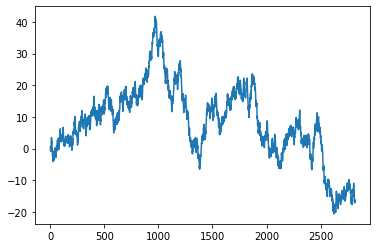

In [129]:
plt.plot(dff.res.values)

In [130]:
dff[dff['res'] == dff['res'].max()].iloc[0].value_1

1.1483662979825193

тут начинаются эти эксперименты с корреляцией и пуассоном

In [219]:
data_test['pred_home'].mean()

1.476468014538112

In [220]:
data_test['pred_away'].mean()

1.1416001461602348

In [221]:
data_test['home_teamStats_goal'].mean()

1.4806938159879337

In [222]:
data_test['away_teamStats_goal'].mean()

1.126395173453997

In [223]:
data_test['diff_home'] = data_test['pred_home'] - data_test['home_teamStats_goal'].mean()

In [224]:
data_test['diff_away'] = data_test['pred_away'] - data_test['away_teamStats_goal'].mean()

In [225]:
np.corrcoef(data_test['diff_home'], data_test['diff_away'])

array([[ 1.        , -0.21618158],
       [-0.21618158,  1.        ]])

In [226]:
data_test['diff_home'].mean()

-0.004225801449818421

In [227]:
data_test['diff_away'].mean()

0.015204972706240213

In [228]:
def rand_poiss_away(row):
    n = np.random.poisson(row['pred_away'])
    return n

def rand_poiss_home(row):
    n = np.random.poisson(row['pred_home'])
    return n

In [246]:
data_test['sim_home'] = data_test.apply(rand_poiss_home, axis=1)
data_test['sim_away'] = data_test.apply(rand_poiss_away, axis=1)

data_test['diff_goals'] = data_test['home_teamStats_goal'] - data_test['away_teamStats_goal']

data_test['diff_sim'] = data_test['sim_home'] - data_test['sim_away']

diff_goals_abs = data_test['diff_goals'].apply(np.abs)

diff_sim_abs = data_test['diff_sim'].apply(np.abs)

(array([1730., 2638., 1355.,  575.,  228.,   73.,   20.,   11.]),
 array([0., 1., 2., 3., 4., 5., 6., 7., 8.]),
 <a list of 8 Patch objects>)

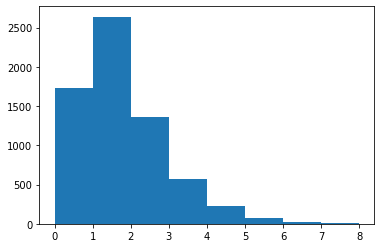

In [247]:
plt.hist(diff_goals_abs, bins=8)

(array([1652., 2551., 1524.,  567.,  222.,   81.,   24.,    6.,    3.]),
 array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 <a list of 9 Patch objects>)

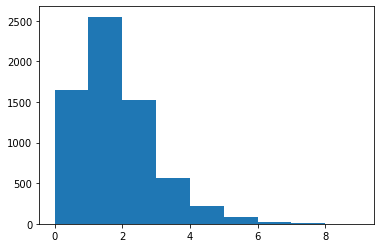

In [245]:
plt.hist(diff_sim_abs, bins=9)

(array([1717., 2557., 1434.,  592.,  245.,   63.,   10.,   12.]),
 array([0., 1., 2., 3., 4., 5., 6., 7., 8.]),
 <a list of 8 Patch objects>)

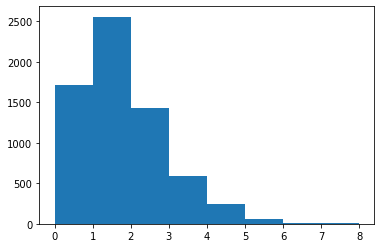

In [249]:
plt.hist(diff_sim_abs, bins=8)

In [190]:
data_test['away_teamStats_goal'].var()

1.245081679816779

тут они кончаются, дальше клетка показывает чистую прибыль и мат ожидание прибыли со ставки по
различным порогам

после этого уже ничего дельного нет

In [79]:
print(np.array(all_profit).mean())
print(np.array(all_roi).mean())
print(np.array(all_profit_120).mean())
print(np.array(all_roi_120).mean())
print(np.array(all_profit_125).mean())
print(np.array(all_roi_125).mean())
print(np.array(all_profit_130).mean())
print(np.array(all_roi_130).mean()) # stats models linear without top leagues

120.65849999999998
0.04277294923410949
89.20799999999998
0.051078949401277496
64.58404999999999
0.06123526343384293
35.218149999999994
0.05837279867617775


In [2504]:
print(np.array(all_profit).mean())
print(np.array(all_roi).mean())
print(np.array(all_profit_120).mean())
print(np.array(all_roi_120).mean())
print(np.array(all_profit_125).mean())
print(np.array(all_roi_125).mean())
print(np.array(all_profit_130).mean())
print(np.array(all_roi_130).mean()) # stats models xgb without top leagues

134.84154687499995
0.04476809957832485
103.20509374999996
0.05457688799761802
76.47676562499998
0.06578738727087889
43.833703124999985
0.06316467882280262


In [2494]:
print(np.array(all_profit).mean())
print(np.array(all_roi).mean())
print(np.array(all_profit_120).mean())
print(np.array(all_roi_120).mean())
print(np.array(all_profit_125).mean())
print(np.array(all_roi_125).mean())
print(np.array(all_profit_130).mean())
print(np.array(all_roi_130).mean()) # stats models linear without top leagues

113.77599999999998
0.0402953205933231
77.73989999999998
0.04403002414676528
51.297099999999986
0.04817567108490372
33.29749999999999
0.053320740399946956


In [2378]:
lr_home

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

In [2384]:
print(np.array(all_profit).mean())
print(np.array(all_roi).mean())
print(np.array(all_profit_120).mean())
print(np.array(all_roi_120).mean())
print(np.array(all_profit_125).mean())
print(np.array(all_roi_125).mean())
print(np.array(all_profit_130).mean())
print(np.array(all_roi_130).mean()) # stats models xgb

148.1008166666666
0.03840327956994139
115.65146666666662
0.04771773793973537
72.76926666666665
0.049196797181632966
53.593333333333334
0.06070419625634827


In [2377]:
print(np.array(all_profit).mean())
print(np.array(all_roi).mean())
print(np.array(all_profit_120).mean())
print(np.array(all_roi_120).mean())
print(np.array(all_profit_125).mean())
print(np.array(all_roi_125).mean())
print(np.array(all_profit_130).mean())
print(np.array(all_roi_130).mean()) # stats models xgb

159.66529999999995
0.041710895890206615
124.63344999999995
0.05194684615053423
69.65669999999997
0.04767731849843345
50.83617499999999
0.057663202751570865


In [2370]:
print(np.array(all_profit).mean())
print(np.array(all_roi).mean())
print(np.array(all_profit_120).mean())
print(np.array(all_roi_120).mean())
print(np.array(all_profit_125).mean())
print(np.array(all_roi_125).mean())
print(np.array(all_profit_130).mean())
print(np.array(all_roi_130).mean()) # stats models linear

145.11304999999996
0.037201529081929904
101.58444999999998
0.04146537989229571
62.37944999999998
0.041291345268265556
33.19399999999999
0.03765394244140402


In [1924]:
data_test

,index,league,home,away,country,season,match_competitionFormat,match_competitionId,date,match_duration,...,pred_bk_home,pred_bk_away,new_goal_home,new_goal_away,pred_home,pred_away,value_1,value_2,value_over,value_under
43980,76047,USA. MLS,DC UnitedUSA,New York CityUSA,USA,2019,domestic_league,33.0,2019-04-21,100.0,...,1.964084,1.270618,-1.178451,2.437629,2.116821,0.965730,1.152371,0.800427,0.908760,1.023064
35731,65303,Denmark. Superliga,EsbjergDNK,MidtjyllandDNK,DNK,2018/2019,domestic_league,30.0,2018-11-04,97.0,...,0.969907,1.785507,2.618056,2.128696,1.205220,1.383149,1.289067,0.673922,0.887411,1.047920
46798,80059,Japan. J2 League,Albirex NiigataJPN,Omiya ArdijaJPN,JPN,2019,domestic_league,110.0,2019-07-06,97.0,...,1.221938,1.154738,2.466837,0.907157,1.279037,1.192615,0.979661,0.933760,0.993093,0.924273
702,16070,Sweden. Allsvenskan,GIF SundsvallSWE,HammarbySWE,SWE,2016,domestic_league,28.0,2016-08-15,95.0,...,1.469031,1.565564,-0.881419,-0.939339,1.534746,1.613460,0.979543,0.975943,1.038076,0.908893
1641,17308,Japan. J1 League,TokyoJPN,Shonan BellmareJPN,JPN,2016,domestic_league,109.0,2016-09-10,97.0,...,1.586111,0.870778,3.848333,-0.522467,1.368367,0.720173,0.909471,1.050907,0.794898,1.170375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25032,50362,Colombia. Primera A,Alianza PetroleraCOL,Jaguares de CórdobaCOL,COL,2018,domestic_league,91.0,2018-03-19,92.0,...,1.192111,0.955444,5.684733,-0.573267,1.030244,1.070413,0.807234,1.123889,0.912390,1.000604
7251,25014,France. Ligue 2,StrasbourgFRA,Gazélec AjaccioFRA,FRA,2016/2017,domestic_league,17.0,2017-02-03,97.0,...,1.213124,0.838858,2.472125,-0.503315,1.203865,0.781858,0.999275,0.961595,0.884779,1.054856
42295,73799,Russia. FNL,SibirRUS,ChertanovoRUS,RUS,2018/2019,domestic_league,122.0,2019-03-30,98.0,...,1.164836,1.097636,0.901099,2.541419,1.288463,1.387669,0.856457,1.036444,1.171015,0.668208
12262,32221,Switzerland. Super League,LuganoCHE,St. GallenCHE,CHE,2016/2017,domestic_league,27.0,2017-05-16,93.0,...,1.752080,1.316080,3.748752,2.410352,1.728938,1.181345,1.014118,0.946127,0.926718,1.030095


In [1925]:
profit_120

[1.0,
 0.5049999999999999,
 -1,
 -1,
 0.909,
 -1,
 -1,
 0.97,
 -1,
 0,
 1.0499999999999998,
 0,
 0,
 -1,
 -1,
 0.847,
 -1,
 -1,
 -1,
 -1,
 -1,
 -0.5,
 -1,
 -1,
 1.0,
 0.97,
 0.909,
 0.99,
 0.97,
 0.7809999999999999,
 0.925,
 1.0299999999999998,
 1.1099999999999999,
 -1,
 0,
 1.06,
 -1,
 0.9609999999999999,
 -1,
 0.7350000000000001,
 -1,
 -1,
 -1,
 -1,
 0.97,
 0,
 0.8919999999999999,
 1.02,
 1.0299999999999998,
 -1,
 1.33,
 0.4165000000000001,
 1.27,
 -1,
 0.909,
 -1,
 -1,
 -0.5,
 1.04,
 0.8619999999999999,
 0.97,
 -0.5,
 1.0899999999999999,
 -1,
 0.7190000000000001,
 -1,
 -1,
 -1,
 1.0299999999999998,
 0.9340000000000002,
 -1,
 0,
 -0.5,
 0.869,
 -1,
 0.8999999999999999,
 1.02,
 0.847,
 1.04,
 -1,
 0.8769999999999998,
 0.99,
 0.847,
 1.2599999999999998,
 -1,
 -0.5,
 -1,
 -1,
 1.0,
 1.0099999999999998,
 -0.5,
 -0.5,
 -1,
 -0.5,
 -1,
 0.8619999999999999,
 -1,
 0.869,
 0.8999999999999999,
 0.99,
 1.12,
 0.4384999999999999,
 -0.5,
 -1,
 0.44200000000000006,
 0.8999999999999999,
 1.12,
 0.9

In [2372]:
lr_home.coef_

array([3.66307398e-02, 4.26136855e-03, 1.69899032e-01, 1.25340190e-01,
       7.51335386e-02, 3.15619947e-02, 1.42262884e-01, 1.32731855e-01,
       3.74598996e-01, 3.91041388e-02, 2.08597673e-04, 5.23123117e-01,
       7.47853718e-02])

In [2374]:
cols_home[:-3]

['mean_home_3_xg',
 'mean_ag_away_3_xg',
 'mean_home_all_xg',
 'mean_ag_away_all_xg',
 'mean_home_3_rev_xg',
 'mean_ag_away_3_rev_xg',
 'mean_home_all_rev_xg',
 'mean_ag_away_all_rev_xg',
 'home_stats',
 'home_stats_3',
 'count_home',
 'home_adv',
 'mean_league_home']

In [2154]:
print(np.array(all_profit).mean())
print(np.array(all_roi).mean())
print(np.array(all_profit_120).mean())
print(np.array(all_roi_120).mean())
print(np.array(all_profit_125).mean())
print(np.array(all_roi_125).mean())
print(np.array(all_profit_130).mean())
print(np.array(all_roi_130).mean()) # смещенный goal на 0.6

135.68061999999992
0.03520071414840184
93.42349166666662
0.03827722185632923
67.74334999999998
0.04527029881163207
42.03140833333332
0.046838265151452285


In [2010]:
print(np.array(all_profit).mean())
print(np.array(all_roi).mean())
print(np.array(all_profit_120).mean())
print(np.array(all_roi_120).mean())
print(np.array(all_profit_125).mean())
print(np.array(all_roi_125).mean())
print(np.array(all_profit_130).mean())
print(np.array(all_roi_130).mean()) # смещенный goal на 0.6

155.5286999999999
0.036666647687308505
106.84924999999996
0.039535771683544364
75.99314999999997
0.045432474528430425
50.894249999999985
0.0499404785008819


In [1880]:
print(np.array(all_profit).mean())
print(np.array(all_roi).mean())
print(np.array(all_profit_120).mean())
print(np.array(all_roi_120).mean())
print(np.array(all_profit_125).mean())
print(np.array(all_roi_125).mean())
print(np.array(all_profit_130).mean())
print(np.array(all_roi_130).mean()) # смещенный goal на 0.6

165.24254999999994
0.036788467904550516
121.04755166666662
0.04172048294833059
85.41231499999996
0.04667574102713572
53.62107999999998
0.0476487765710327


In [1873]:
print(np.array(all_profit).mean())
print(np.array(all_roi).mean())
print(np.array(all_profit_120).mean())
print(np.array(all_roi_120).mean())
print(np.array(all_profit_125).mean())
print(np.array(all_roi_125).mean())
print(np.array(all_profit_130).mean())
print(np.array(all_roi_130).mean()) # смещенный goal нью фичи

120.59849999999993
0.02668698827174152
97.03849999999996
0.03364719140083216
76.85099999999997
0.0424356709000552
61.97149999999998
0.05557982062780267


In [1685]:
print(np.array(all_profit).mean())
print(np.array(all_roi).mean())
print(np.array(all_profit_120).mean())
print(np.array(all_roi_120).mean())
print(np.array(all_profit_125).mean())
print(np.array(all_roi_125).mean())
print(np.array(all_profit_130).mean())
print(np.array(all_roi_130).mean()) # нью фичи 

145.26165333333327
0.03584576281803613
121.1268383333333
0.04651971478054637
92.39554333333331
0.056819980990560334
53.42808499999999
0.054128291349779145


In [1644]:
print(np.array(all_profit).mean())
print(np.array(all_roi).mean())
print(np.array(all_profit_120).mean())
print(np.array(all_roi_120).mean())
print(np.array(all_profit_125).mean())
print(np.array(all_roi_125).mean())
print(np.array(all_profit_130).mean())
print(np.array(all_roi_130).mean()) # смещенный goal

160.7984766666666
0.03788564799863441
111.9993033333333
0.04132031625320066
84.82456999999998
0.050292017083263404
54.06665666666665
0.05269379995289717


In [1589]:
print(np.array(all_profit).mean())
print(np.array(all_roi).mean())
print(np.array(all_profit_120).mean())
print(np.array(all_roi_120).mean())
print(np.array(all_profit_125).mean())
print(np.array(all_roi_125).mean())
print(np.array(all_profit_130).mean())
print(np.array(all_roi_130).mean()) # линрега со сдвигом

149.22439999999995
0.03882658643682009
112.78299999999994
0.04645233559347891
92.17393333333331
0.06158139769032982
54.01509999999998
0.06038098415538035


In [1602]:
print(np.array(all_profit).mean())
print(np.array(all_roi).mean())
print(np.array(all_profit_120).mean())
print(np.array(all_roi_120).mean())
print(np.array(all_profit_125).mean())
print(np.array(all_roi_125).mean())
print(np.array(all_profit_130).mean())
print(np.array(all_roi_130).mean()) #хгбуст со сдвигом

142.5101666666666
0.038743461417373344
109.21283333333331
0.04772372424138655
79.2983333333333
0.056905895099458016
44.48633333333332
0.05364236715052638


In [1512]:
print(np.array(all_profit).mean())
print(np.array(all_roi).mean())
print(np.array(all_profit_120).mean())
print(np.array(all_roi_120).mean())
print(np.array(all_profit_125).mean())
print(np.array(all_roi_125).mean())
print(np.array(all_profit_130).mean())
print(np.array(all_roi_130).mean())

139.8834549999999
0.03465511525298604
89.27136833333329
0.03514805276673357
80.41824833333331
0.05123299959467187
45.485966666666656
0.047880826317734534


In [1509]:
print(np.array(all_profit).mean())
print(np.array(all_roi).mean())

139.8834549999999
0.03465511525298604


In [1214]:
np.array(all_profit).mean()

101.05954999999996

In [1215]:
np.array(all_roi).mean()

0.031869185442674954

In [1201]:
np.array(all_profit).mean()

134.11194999999998

In [1202]:
np.array(all_roi).mean()

0.03988973416724152

In [1184]:
print(len(profit))
print(len(types))
print(len(data_test))

3325
3325
8740


In [1185]:
prof_df = pd.DataFrame()
prof_df['profit'] = profit
prof_df['types'] = types

In [1186]:
ind = 0

In [1187]:
np.array(profit).sum()

150.59299999999996

In [1188]:
np.array(profit).mean()

0.04529112781954886

In [1189]:
len(profit)

3325

In [1190]:
len(types)

3325

In [1191]:
prof_df[prof_df['types'] == 'over'].profit.mean()

0.08647948016415866

In [1192]:
prof_df[prof_df['types'] == 'under'].profit.mean()

0.05205726405090135

In [ ]:
# probs1 = []
# probs2 = []
# for i in range(0, 20):
#     probs1.append(pois(i, 1.635175))
#     probs2.append(pois(i, 1.378408))

data_test['pred_home'].mean() + data_test['pred_away'].mean()

data_test['value_under'].mean()

data_test[['over_open', 'under_open', 'total_open', 'pred_home', 'pred_away', 'value_over', 'value_under']]


data_test[['f1_open', 'f2_open', 'hand_open', 'pred_home', 'pred_away', 'value_1', 'value_2']]

In [1440]:
data2 = data1

In [1441]:
data2 = data2[data2['count_home_home'] > 4]
data2 = data2[data2['count_home_away'] > 4]
data2 = data2[data2['count_away_home'] > 4]
data2 = data2[data2['count_away_away'] > 4]

In [1444]:
data2.columns[-30:]

Index(['away_adv', 'mean_league_home', 'mean_league_away', 'count_home',
       'count_away', 'p1_open', 'x_open', 'p2_open', 'hand_open', 'f1_open',
       'f2_open', 'total_open', 'over_open', 'under_open', 'p1_close',
       'x_close', 'p2_close', 'hand_close', 'f1_close', 'f2_close',
       'total_close', 'over_close', 'under_close', 'score', 'date_score',
       'date_new', 'pred_bk_home', 'pred_bk_away', 'new_goal_home',
       'new_goal_away'],
      dtype='object')

In [1445]:
data2['pred_home'] = (data2['mean_home_all_xg'] * data2['mean_ag_away_all_xg']) / data2['mean_league_home']
data2['pred_away'] = (data2['mean_away_all_xg'] * data2['mean_ag_home_all_xg']) / data2['mean_league_away']


In [1448]:
data2['pred_away'].mean()

1.1818359190736654

In [1449]:
data2['value_1'] = data2.apply(value_1, axis=1)
data2['value_2'] = data2.apply(value_2, axis=1)

data2['value_over'] = data2.apply(value_over, axis=1)
data2['value_under'] = data2.apply(value_under, axis=1)

In [1470]:
threshold_hand = 1.3
threshold_total = 1.3

In [1471]:
profit = []
types = []
profit_120 = []
profit_125 = []
profit_130 = []
for i, row in data_test.iterrows():
    if (row['value_1'] > threshold_hand):
        if (equal(row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'], 0)):
            profit.append(0)
            types.append('f1')
        if (equal(row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'], 0.25)):
            profit.append((row['f1_open'] - 1) / 2)
            types.append('f1')
        if (equal(row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'], -0.25)):
            profit.append(-0.5)
            types.append('f1')
        if (row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'] < -0.4):
            profit.append(-1)
            types.append('f1')
        if (row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'] > 0.4):
            profit.append(row['f1_open'] - 1)
            types.append('f1')
        if (row['value_1'] > 1.25):
            profit_120.append(profit[-1])
        if (row['value_1'] > 1.30):
            profit_125.append(profit[-1])
        if (row['value_1'] > 1.35):
            profit_130.append(profit[-1])

    if (row['value_2'] > threshold_hand):
        if (equal(row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'], 0)):
            profit.append(0)
            types.append('f2')
        if (equal(row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'], -0.25)):
            profit.append((row['f2_open'] - 1) / 2)
            types.append('f2')
        if (equal(row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'], 0.25)):
            profit.append(-0.5)
            types.append('f2')
        if (row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'] < -0.4):
            profit.append(row['f2_open'] - 1)
            types.append('f2')
        if (row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'] > 0.4):
            profit.append(-1)
            types.append('f2')
        if (row['value_2'] > 1.25):
            profit_120.append(profit[-1])
        if (row['value_2'] > 1.30):
            profit_125.append(profit[-1])
        if (row['value_2'] > 1.35):
            profit_130.append(profit[-1])

    if (row['value_over'] > threshold_total):
        if (equal(row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'], 0)):
            profit.append(0)
            types.append('over')
        if (equal(row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'], 0.25)):
            profit.append((row['over_open'] - 1) / 2)
            types.append('over')
        if (equal(row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'], -0.25)):
            profit.append(-0.5)
            types.append('over')
        if (row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'] < -0.4):
            profit.append(-1)
            types.append('over')
        if (row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'] > 0.4):
            profit.append(row['over_open'] - 1)
            types.append('over')
        if (row['value_over'] > 1.20):
            profit_120.append(profit[-1])
        if (row['value_over'] > 1.25):
            profit_125.append(profit[-1])
        if (row['value_over'] > 1.30):
            profit_130.append(profit[-1])

    if (row['value_under'] > threshold_total):
        if (equal(row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'], 0)):
            profit.append(0)
            types.append('under')
        if (equal(row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'], -0.25)):
            profit.append((row['under_open'] - 1) / 2)
            types.append('under')
        if (equal(row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'], 0.25)):
            profit.append(-0.5)
            types.append('under')
        if (row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'] < -0.4):
            profit.append(row['under_open'] - 1)
            types.append('under')
        if (row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'] > 0.4):
            profit.append(-1)
            types.append('under')
        if (row['value_under'] > 1.20):
            profit_120.append(profit[-1])
        if (row['value_under'] > 1.25):
            profit_125.append(profit[-1])
        if (row['value_under'] > 1.30):
            profit_130.append(profit[-1])

In [1472]:
np.array(profit).mean()

0.04747448096885812

In [1473]:
np.array(profit).sum()

54.880499999999984

In [1457]:
len(data2)

36686

In [ ]:
all_profit = []
all_roi = []
all_profit_120 = []
all_roi_120 = []
all_profit_125 = []
all_roi_125 = []
all_profit_130 = []
all_roi_130 = []
for count in range(0, 10):
    
    data_home = data1[cols_home]
    data_away = data1[cols_away]
    
    if (count % 1 == 0):
        print(count)
    a = np.arange(int(len(data1)))

    np.random.shuffle(a)

    nums = a[int(len(X_home) / 5):]
    nums1 = a[:int(len(X_home) / 5)]

    #Mlen(nums)

    X_home_train = X_home.iloc[nums]
    y_home_train = y_home.iloc[nums]

    X_away_train = X_away.iloc[nums]
    y_away_train = y_away.iloc[nums]

    lr_home = LinearRegression()
    lr_away = LinearRegression()

    lr_home.fit(X_home_train, y_home_train)
    lr_away.fit(X_away_train, y_away_train)

    data_test = data1.iloc[nums1]
    print(len(data_test))

    


    home_test = data_test[cols_home]

    away_test = data_test[cols_away]

    home_test = home_test.drop(['home_teamStats_xgShot', 'home_teamStats_goal', 'new_goal_home'], axis=1)
    away_test = away_test.drop(['away_teamStats_xgShot', 'away_teamStats_goal', 'new_goal_away'], axis=1)

    # away_test.head()

    # away_test.mean_ag_home_3_xg.mean()

    pred_home = lr_home.predict(home_test)
    pred_away = lr_away.predict(away_test)

    # pred_home.mean()

    data_test['pred_home'] = pred_home
    data_test['pred_away'] = pred_away

    # data1.columns[-30:]



    data_test['value_1'] = data_test.apply(value_1, axis=1)
    data_test['value_2'] = data_test.apply(value_2, axis=1)

    data_test_1 = data_test[:10]

    data_test['value_over'] = data_test.apply(value_over, axis=1)
    data_test['value_under'] = data_test.apply(value_under, axis=1)

    # data_test[['over_open', 'under_open', 'total_open', 'pred_home', 'pred_away', 'value_over', 'value_under']]


    threshold_hand = 1.2

    threshold_total = 1.15

    def equal(a, b):
        if (np.abs(a - b) < 0.01):
            return True
        else:
            return False

    profit = []
    types = []
    profit_120 = []
    profit_125 = []
    profit_130 = []
    for i, row in data_test.iterrows():
        if (row['value_1'] > threshold_hand):
            if (equal(row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'], 0)):
                profit.append(0)
                types.append('f1')
            if (equal(row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'], 0.25)):
                profit.append((row['f1_open'] - 1) / 2)
                types.append('f1')
            if (equal(row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'], -0.25)):
                profit.append(-0.5)
                types.append('f1')
            if (row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'] < -0.4):
                profit.append(-1)
                types.append('f1')
            if (row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'] > 0.4):
                profit.append(row['f1_open'] - 1)
                types.append('f1')
            if (row['value_1'] > 1.25):
                profit_120.append(profit[-1])
            if (row['value_1'] > 1.30):
                profit_125.append(profit[-1])
            if (row['value_1'] > 1.35):
                profit_130.append(profit[-1])
                
        if (row['value_2'] > threshold_hand):
            if (equal(row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'], 0)):
                profit.append(0)
                types.append('f2')
            if (equal(row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'], -0.25)):
                profit.append((row['f2_open'] - 1) / 2)
                types.append('f2')
            if (equal(row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'], 0.25)):
                profit.append(-0.5)
                types.append('f2')
            if (row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'] < -0.4):
                profit.append(row['f2_open'] - 1)
                types.append('f2')
            if (row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'] > 0.4):
                profit.append(-1)
                types.append('f2')
            if (row['value_2'] > 1.25):
                profit_120.append(profit[-1])
            if (row['value_2'] > 1.30):
                profit_125.append(profit[-1])
            if (row['value_2'] > 1.35):
                profit_130.append(profit[-1])

        if (row['value_over'] > threshold_total):
            if (equal(row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'], 0)):
                profit.append(0)
                types.append('over')
            if (equal(row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'], 0.25)):
                profit.append((row['over_open'] - 1) / 2)
                types.append('over')
            if (equal(row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'], -0.25)):
                profit.append(-0.5)
                types.append('over')
            if (row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'] < -0.4):
                profit.append(-1)
                types.append('over')
            if (row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'] > 0.4):
                profit.append(row['over_open'] - 1)
                types.append('over')
            if (row['value_over'] > 1.20):
                profit_120.append(profit[-1])
            if (row['value_over'] > 1.25):
                profit_125.append(profit[-1])
            if (row['value_over'] > 1.30):
                profit_130.append(profit[-1])
                
        if (row['value_under'] > threshold_total):
            if (equal(row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'], 0)):
                profit.append(0)
                types.append('under')
            if (equal(row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'], -0.25)):
                profit.append((row['under_open'] - 1) / 2)
                types.append('under')
            if (equal(row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'], 0.25)):
                profit.append(-0.5)
                types.append('under')
            if (row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'] < -0.4):
                profit.append(row['under_open'] - 1)
                types.append('under')
            if (row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'] > 0.4):
                profit.append(-1)
                types.append('under')
            if (row['value_under'] > 1.20):
                profit_120.append(profit[-1])
            if (row['value_under'] > 1.25):
                profit_125.append(profit[-1])
            if (row['value_under'] > 1.30):
                profit_130.append(profit[-1])

    pr = np.array(profit).sum()
    roi = np.array(profit).mean()
    pr_120 = np.array(profit_120).sum()
    roi_120 = np.array(profit_120).mean()
    pr_125 = np.array(profit_125).sum()
    roi_125 = np.array(profit_125).mean()
    pr_130 = np.array(profit_130).sum()
    roi_130 = np.array(profit_130).mean()
    all_profit.append(pr)
    all_roi.append(roi)
    all_profit_120.append(pr_120)
    all_roi_120.append(roi_120)
    all_profit_125.append(pr_125)
    all_roi_125.append(roi_125)
    all_profit_130.append(pr_130)
    all_roi_130.append(roi_130)
    

In [ ]:
all_profit = []
all_roi = []
all_profit_120 = []
all_roi_120 = []
all_profit_125 = []
all_roi_125 = []
all_profit_130 = []
all_roi_130 = []
for count in range(0, 1):
    if (count % 1 == 0):
        print(count)
    a = np.arange(int(len(data1)))

    np.random.shuffle(a)

    nums = a[int(len(X_home) / 5):]
    nums1 = a[:int(len(X_home) / 5)]
    
    data_train = data1.iloc[nums1]
    data_test = data1.iloc[nums1]
    
    for cc in range(0, 12, 2):
        print(cc, 'cc')
        cols_home = sett[cc][1:]
        cols_away = sett[cc+1][1:]
#         data_home = data1[sett[i]]
#         data_away = data1[sett[i+1]]
        first_h = sett[cc][0]
        first_a = sett[cc+1][0]
        #print(first_h, first_a)
        
        X_home = data_train[cols_home]
        y_home = data_train[first_h]

        X_away = data_train[cols_away]
        y_away = data_train[first_a]


        #Mlen(nums)

        X_home_train = X_home#.iloc[nums]
        y_home_train = y_home#.iloc[nums]

        X_away_train = X_away#.iloc[nums]
        y_away_train = y_away#.iloc[nums]

        lr_home = LinearRegression()
        lr_away = LinearRegression()

        lr_home.fit(X_home_train, y_home_train)
        lr_away.fit(X_away_train, y_away_train)


        home_test = data_test[cols_home]

        away_test = data_test[cols_away]

        #home_test = home_test.drop([first_h], axis=1)
        #away_test = away_test.drop([first_a], axis=1)

        # away_test.head()

        # away_test.mean_ag_home_3_xg.mean()

        pred_home = lr_home.predict(home_test)
        pred_away = lr_away.predict(away_test)

        # pred_home.mean()
        name_home = 'pred_home_' + stats[cc//2]
        name_away = 'pred_away_' + stats[cc//2]

        data_test[name_home] = pred_home
        data_test[name_away] = pred_away
        
        
    cols_home = home_cols
    cols_away = away_cols
    data_home = data1[home_cols]
    data_away = data1[away_cols]
    first_h = 'home_teamStats_goal'
    first_a = 'away_teamStats_goal'

    X_home = data_home.drop([first_h], axis=1)
    y_home = data_home[first_h]

    X_away = data_away.drop([first_a], axis=1)
    y_away = data_away[first_a]


    #Mlen(nums)

    X_home_train = X_home.iloc[nums]
    y_home_train = y_home.iloc[nums]

    X_away_train = X_away.iloc[nums]
    y_away_train = y_away.iloc[nums]

    lr_home = LinearRegression()
    lr_away = LinearRegression()

    lr_home.fit(X_home_train, y_home_train)
    lr_away.fit(X_away_train, y_away_train)

    #data_test = data1.iloc[nums1]
    print(len(data_test))




#     home_test = data_test[cols_home]

#     away_test = data_test[cols_away]

#     home_test = home_test.drop([first_h], axis=1)
#     away_test = away_test.drop([first_a], axis=1)

    # away_test.head()

    # away_test.mean_ag_home_3_xg.mean()

    pred_home = lr_home.predict(data_test[preds_cols_home])
    pred_away = lr_away.predict(data_test[preds_cols_away])

    # pred_home.mean()
#     name_home = 'pred_home_' + stats[i//2]
#     name_away = 'pred_away_' + stats[i//2]

    data_test['pred_home'] = pred_home
    data_test['pred_away'] = pred_away

    # data1.columns[-30:]



    data_test['value_1'] = data_test.apply(value_1, axis=1)
    data_test['value_2'] = data_test.apply(value_2, axis=1)

    data_test_1 = data_test[:10]

    data_test['value_over'] = data_test.apply(value_over, axis=1)
    data_test['value_under'] = data_test.apply(value_under, axis=1)

    # data_test[['over_open', 'under_open', 'total_open', 'pred_home', 'pred_away', 'value_over', 'value_under']]


    threshold_hand = 1.2

    threshold_total = 1.15

    def equal(a, b):
        if (np.abs(a - b) < 0.01):
            return True
        else:
            return False

    profit = []
    types = []
    profit_120 = []
    profit_125 = []
    profit_130 = []
    for i, row in data_test.iterrows():
        if (row['value_1'] > threshold_hand):
            if (equal(row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'], 0)):
                profit.append(0)
                types.append('f1')
            if (equal(row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'], 0.25)):
                profit.append((row['f1_open'] - 1) / 2)
                types.append('f1')
            if (equal(row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'], -0.25)):
                profit.append(-0.5)
                types.append('f1')
            if (row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'] < -0.4):
                profit.append(-1)
                types.append('f1')
            if (row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'] > 0.4):
                profit.append(row['f1_open'] - 1)
                types.append('f1')
            if (row['value_1'] > 1.25):
                profit_120.append(profit[-1])
            if (row['value_1'] > 1.30):
                profit_125.append(profit[-1])
            if (row['value_1'] > 1.35):
                profit_130.append(profit[-1])
                
        if (row['value_2'] > threshold_hand):
            if (equal(row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'], 0)):
                profit.append(0)
                types.append('f2')
            if (equal(row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'], -0.25)):
                profit.append((row['f2_open'] - 1) / 2)
                types.append('f2')
            if (equal(row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'], 0.25)):
                profit.append(-0.5)
                types.append('f2')
            if (row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'] < -0.4):
                profit.append(row['f2_open'] - 1)
                types.append('f2')
            if (row['home_teamStats_goal'] - row['away_teamStats_goal'] + row['hand_open'] > 0.4):
                profit.append(-1)
                types.append('f2')
            if (row['value_2'] > 1.25):
                profit_120.append(profit[-1])
            if (row['value_2'] > 1.30):
                profit_125.append(profit[-1])
            if (row['value_2'] > 1.35):
                profit_130.append(profit[-1])

        if (row['value_over'] > threshold_total):
            if (equal(row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'], 0)):
                profit.append(0)
                types.append('over')
            if (equal(row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'], 0.25)):
                profit.append((row['over_open'] - 1) / 2)
                types.append('over')
            if (equal(row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'], -0.25)):
                profit.append(-0.5)
                types.append('over')
            if (row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'] < -0.4):
                profit.append(-1)
                types.append('over')
            if (row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'] > 0.4):
                profit.append(row['over_open'] - 1)
                types.append('over')
            if (row['value_over'] > 1.20):
                profit_120.append(profit[-1])
            if (row['value_over'] > 1.25):
                profit_125.append(profit[-1])
            if (row['value_over'] > 1.30):
                profit_130.append(profit[-1])
                
        if (row['value_under'] > threshold_total):
            if (equal(row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'], 0)):
                profit.append(0)
                types.append('under')
            if (equal(row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'], -0.25)):
                profit.append((row['under_open'] - 1) / 2)
                types.append('under')
            if (equal(row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'], 0.25)):
                profit.append(-0.5)
                types.append('under')
            if (row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'] < -0.4):
                profit.append(row['under_open'] - 1)
                types.append('under')
            if (row['home_teamStats_goal'] + row['away_teamStats_goal'] - row['total_open'] > 0.4):
                profit.append(-1)
                types.append('under')
            if (row['value_under'] > 1.20):
                profit_120.append(profit[-1])
            if (row['value_under'] > 1.25):
                profit_125.append(profit[-1])
            if (row['value_under'] > 1.30):
                profit_130.append(profit[-1])

    pr = np.array(profit).sum()
    roi = np.array(profit).mean()
    pr_120 = np.array(profit_120).sum()
    roi_120 = np.array(profit_120).mean()
    pr_125 = np.array(profit_125).sum()
    roi_125 = np.array(profit_125).mean()
    pr_130 = np.array(profit_130).sum()
    roi_130 = np.array(profit_130).mean()
    all_profit.append(pr)
    all_roi.append(roi)
    all_profit_120.append(pr_120)
    all_roi_120.append(roi_120)
    all_profit_125.append(pr_125)
    all_roi_125.append(roi_125)
    all_profit_130.append(pr_130)
    all_roi_130.append(roi_130)
    

In [2237]:
sorted(data.league_season.unique())

['Argentina. Prim B Nacional2016/2017',
 'Argentina. Prim B Nacional2017/2018',
 'Argentina. Prim B Nacional2018/2019',
 'Argentina. Prim B Nacional2019/2020',
 'Argentina. Superliga2016',
 'Argentina. Superliga2016/2017',
 'Argentina. Superliga2017/2018',
 'Argentina. Superliga2018/2019',
 'Argentina. Superliga2019/2020',
 'Armenia. Premier League2018/2019',
 'Armenia. Premier League2019/2020',
 'Austria. 2. Liga2016/2017',
 'Austria. 2. Liga2017/2018',
 'Austria. 2. Liga2018/2019',
 'Austria. 2. Liga2019/2020',
 'Austria. Bundesliga2015/2016',
 'Austria. Bundesliga2016/2017',
 'Austria. Bundesliga2017/2018',
 'Austria. Bundesliga2018/2019',
 'Austria. Bundesliga2019/2020',
 'Azerbaijan. Premyer Liqa2016/2017',
 'Azerbaijan. Premyer Liqa2017/2018',
 'Azerbaijan. Premyer Liqa2018/2019',
 'Azerbaijan. Premyer Liqa2019/2020',
 'Belgium. First Division A2015/2016',
 'Belgium. First Division A2016/2017',
 'Belgium. First Division A2017/2018',
 'Belgium. First Division A2018/2019',
 'Belgiu

In [2238]:
data_it = data[data['league_season'] == 'Colombia. Primera A2016']

In [2239]:
data_it2 = data_it[['home', 'away', 'home_teamStats_xgShot', 'away_teamStats_xgShot']]

In [2240]:
data_it2 = data_it[['home', 'away', 'home_teamStats_goal', 'away_teamStats_goal']]

In [2241]:
for i in data_it['home'].unique():
    print(i, (data_it[data_it['home'] == i].home_teamStats_xgShot.mean() + data_it[data_it['away'] == i].away_teamStats_xgShot.mean())/2,
          (data_it[data_it['home'] == i].home_teamStats_goal.mean() + data_it[data_it['away'] == i].away_teamStats_goal.mean())/2)
    

CortuluáCOL 1.1692253684210525 1.3421052631578947
Deportes TolimaCOL 1.1524466999999998 1.1
Boyacá ChicóCOL 1.1120506 0.9166666666666667
FortalezaCOL 0.9301479084967321 0.977124183006536
Once CaldasCOL 1.420534978328173 1.2987616099071206
Atlético NacionalCOL 1.4545280869565216 1.7608695652173914
EnvigadoCOL 0.9256108606811145 1.1377708978328174
JuniorCOL 1.4626376491228066 1.288220551378446
Atlético BucaramangaCOL 1.1091709191919192 1.1515151515151516
MillonariosCOL 1.400202095238095 1.475
Atlético HuilaCOL 0.8444085694444443 0.6666666666666666
Patriotas BoyacáCOL 1.152704 1.1578947368421053
La EquidadCOL 1.1213071497975708 1.119433198380567
Alianza PetroleraCOL 1.131480954248366 1.2630718954248366
Deportivo PastoCOL 1.2366809845201236 0.9411764705882353
Jaguares de CórdobaCOL 0.9888896666666667 0.8333333333333334
Deportivo CaliCOL 1.5623419365079365 1.4325396825396826
Santa FeCOL 1.3570092280701753 1.3230994152046782
MedellínCOL 1.5854580952380952 1.6004140786749481
Rionegro ÁguilasC

In [2242]:
print(data_it.home_teamStats_xgShot.mean())
print(data_it.home_teamStats_goal.mean())
print(data_it.away_teamStats_xgShot.mean())
print(data_it.away_teamStats_goal.mean())

1.417887234042554
1.4441489361702127
1.0371927234042542
1.0053191489361701


In [2243]:
data_it[data_it['home'] == 'SampdoriaITA'].home_teamStats_goal.mean()

nan

In [2244]:
data_it2.columns = ['HomeTeam', 'AwayTeam', 'HomeGoals', 'AwayGoals']

In [2245]:
data_it2

,HomeTeam,AwayTeam,HomeGoals,AwayGoals
63684,CortuluáCOL,Deportivo CaliCOL,4.0,1.0
64027,Deportes TolimaCOL,Rionegro ÁguilasCOL,0.0,3.0
64222,Boyacá ChicóCOL,Santa FeCOL,0.0,1.0
3743,FortalezaCOL,Jaguares de CórdobaCOL,1.0,2.0
63411,Once CaldasCOL,Deportivo PastoCOL,0.0,0.0
...,...,...,...,...
63999,Atlético BucaramangaCOL,Deportes TolimaCOL,1.0,0.0
63998,Deportes TolimaCOL,Atlético BucaramangaCOL,2.0,1.0
63231,Atlético NacionalCOL,Santa FeCOL,0.0,4.0
63997,Deportes TolimaCOL,Santa FeCOL,0.0,0.0


In [2246]:
skellam.pmf(0.0,  data_it2.mean()[0],  data_it2.mean()[1])


nan

In [2247]:
goal_model_data = pd.concat([data_it2[['HomeTeam','AwayTeam','HomeGoals']].assign(home=1).rename(
            columns={'HomeTeam':'team', 'AwayTeam':'opponent','HomeGoals':'goals'}),
           data_it2[['AwayTeam','HomeTeam','AwayGoals']].assign(home=0).rename(
            columns={'AwayTeam':'team', 'HomeTeam':'opponent','AwayGoals':'goals'})])

In [2248]:
poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data, 
                        family=sm.families.Poisson()).fit()

In [4]:
goal_model_data

NameError: name 'goal_model_data' is not defined

In [ ]:
poisson_model.

In [2250]:
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                  752
Model:                            GLM   Df Residuals:                      712
Model Family:                 Poisson   Df Model:                           39
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1007.2
Date:                Sun, 09 Feb 2020   Deviance:                       729.04
Time:                        15:56:04   Pearson chi2:                     633.
No. Iterations:                     5   Covariance Type:             nonrobust
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               0.2524      0.212      1.191      0.233      -0.163       0.668
team[T.Atlético BucaramangaCOL]        -0.1000      0.212     -0.471      0.638      -0.516       0.316
team[T.Atlético HuilaCOL]              -0.6738      0.262     -2.572      0.010      -1.187      -0.160
team[T.Atlético NacionalCOL]            0.3101      0.188      1.649      0.099      -0.058       0.679
team[T.Boyacá ChicóCOL]                -0.3271      0.235     -1.391      0.164      -0.788       0.134
team[T.CortuluáCOL]                     0.0616      0.207      0.298      0.766      -0.344       0.467
team[T.Deportes TolimaCOL]             -0.1676      0.214     -0.783      0.434      -0.587       0.252
team[T.Deportivo CaliCOL]               0.1047      0.201      0.521      0.602      -0.289       0.498
team[T.Deportivo PastoCOL]             -0.3058      0.229     -1.335      0.182      -0.755       0.143
team[T.EnvigadoCOL]                    -0.1537      0.218     -0.705      0.481      -0.581       0.273
team[T.FortalezaCOL]                   -0.2864      0.229     -1.250      0.211      -0.735       0.163
team[T.Jaguares de CórdobaCOL]         -0.4376      0.238     -1.842      0.065      -0.903       0.028
team[T.JuniorCOL]                       0.0075      0.206      0.037      0.971      -0.396       0.411
team[T.La EquidadCOL]                  -0.1638      0.224     -0.732      0.464      -0.603       0.275
team[T.MedellínCOL]                     0.2113      0.193      1.093      0.274      -0.168       0.590
team[T.MillonariosCOL]                  0.1351      0.199      0.678      0.498      -0.255       0.526
team[T.Once CaldasCOL]                 -0.0292      0.211     -0.139      0.890      -0.442       0.384
team[T.Patriotas BoyacáCOL]            -0.1140      0.214     -0.533      0.594      -0.533       0.305
team[T.Rionegro ÁguilasCOL]             0.0007      0.212      0.003      0.997      -0.414       0.416
team[T.Santa FeCOL]                     0.0216      0.209      0.104      0.917      -0.387       0.430
opponent[T.Atlético BucaramangaCOL]    -0.2389      0.201     -1.187      0.235      -0.633       0.155
opponent[T.Atlético HuilaCOL]          -0.0614      0.201     -0.305      0.760      -0.455       0.333
opponent[T.Atlético NacionalCOL]       -0.3706      0.202     -1.835      0.067      -0.766       0.025
opponent[T.Boyacá ChicóCOL]             0.0140      0.200      0.070      0.944      -0.377       0.405
opponent[T.CortuluáCOL]                -0.1197      0.197     -0.608      0.543      -0.506       0.266
opponent[T.Deportes TolimaCOL]         -0.2658      0.206     -1.292      0.196      -0.669       0.137
opponent[T.Deportivo CaliCOL]          -0.2068      0.204     -1.016      0.310      -0.606       0.192
opponent[T.Deportivo PastoCOL]         -0.

In [2251]:
poisson_model.predict(pd.DataFrame(data={'team': 'SassuoloITA', 'opponent': 'LazioITA',
                                       'home':1},index=[1])).iloc[0]


PatsyError: Error converting data to categorical: observation with value 'SassuoloITA' does not match any of the expected levels (expected: ['Alianza PetroleraCOL', 'Atlético BucaramangaCOL', ..., 'Rionegro ÁguilasCOL', 'Santa FeCOL'])
    goals ~ home + team + opponent
                   ^^^^

In [2252]:
2.71 ** 0.2148

1.2388017314197013

In [2253]:
def pred_home(row):
    pred = poisson_model.predict(pd.DataFrame(data={'team': row['home'], 'opponent': row['away'],
                                       'home':1},index=[1])).iloc[0]
    return pred

def pred_away(row):
    pred = poisson_model.predict(pd.DataFrame(data={'team': row['away'], 'opponent': row['home'],
                                       'home':0},index=[1])).iloc[0]
    return pred

In [2254]:
data_it.apply(pred_home, axis=1).mean()

1.444148936170214

In [2164]:
a = data_it.apply(pred_away, axis=1)

In [2165]:
a.mean()

1.2404568421108397

In [2173]:
data_it['pred_home'] = data_it.apply(pred_home, axis=1)
data_it['pred_away'] = data_it.apply(pred_away, axis=1)

In [2179]:
data_it.count_home

8886      0.0
12216     0.0
8564      0.0
9422      0.0
9296      0.0
         ... 
8694     37.0
12205    37.0
9395     37.0
9131     37.0
10632    37.0
Name: count_home, Length: 380, dtype: float64

In [2280]:
stats_pred = data_it.apply(all_features_statsmod, axis=1)

CortuluáCOL2016 Deportivo CaliCOL2016
CortuluáCOL2016 Deportivo CaliCOL2016
Deportes TolimaCOL2016 Rionegro ÁguilasCOL2016
Boyacá ChicóCOL2016 Santa FeCOL2016
FortalezaCOL2016 Jaguares de CórdobaCOL2016
Once CaldasCOL2016 Deportivo PastoCOL2016
Atlético NacionalCOL2016 Alianza PetroleraCOL2016
EnvigadoCOL2016 La EquidadCOL2016
JuniorCOL2016 Atlético HuilaCOL2016
Atlético BucaramangaCOL2016 MedellínCOL2016
MillonariosCOL2016 Patriotas BoyacáCOL2016
Atlético HuilaCOL2016 EnvigadoCOL2016
Patriotas BoyacáCOL2016 Atlético BucaramangaCOL2016
La EquidadCOL2016 CortuluáCOL2016
Alianza PetroleraCOL2016 Once CaldasCOL2016
Deportivo PastoCOL2016 Boyacá ChicóCOL2016
Jaguares de CórdobaCOL2016 Atlético NacionalCOL2016
Deportivo CaliCOL2016 Deportes TolimaCOL2016
Santa FeCOL2016 MillonariosCOL2016
FortalezaCOL2016 Deportes TolimaCOL2016
Once CaldasCOL2016 Jaguares de CórdobaCOL2016
MillonariosCOL2016 Deportivo PastoCOL2016
JuniorCOL2016 Patriotas BoyacáCOL2016
EnvigadoCOL2016 MedellínCOL2016
La Equi

JuniorCOL2016 MedellínCOL2016
Once CaldasCOL2016 Alianza PetroleraCOL2016
Jaguares de CórdobaCOL2016 Once CaldasCOL2016
Deportivo CaliCOL2016 La EquidadCOL2016
Deportes TolimaCOL2016 FortalezaCOL2016
Santa FeCOL2016 Atlético BucaramangaCOL2016
FortalezaCOL2016 Deportivo CaliCOL2016
Once CaldasCOL2016 Rionegro ÁguilasCOL2016
CortuluáCOL2016 MedellínCOL2016
Atlético NacionalCOL2016 Deportes TolimaCOL2016
JuniorCOL2016 Santa FeCOL2016
La EquidadCOL2016 Atlético HuilaCOL2016
MillonariosCOL2016 Alianza PetroleraCOL2016
EnvigadoCOL2016 Patriotas BoyacáCOL2016
Boyacá ChicóCOL2016 Jaguares de CórdobaCOL2016
MillonariosCOL2016 Once CaldasCOL2016
Alianza PetroleraCOL2016 Atlético BucaramangaCOL2016
Deportivo PastoCOL2016 JuniorCOL2016
Patriotas BoyacáCOL2016 CortuluáCOL2016
Rionegro ÁguilasCOL2016 Boyacá ChicóCOL2016
MedellínCOL2016 La EquidadCOL2016
Deportes TolimaCOL2016 Once CaldasCOL2016
Atlético HuilaCOL2016 Deportivo CaliCOL2016
FortalezaCOL2016 Atlético NacionalCOL2016
Jaguares de Córdoba

In [2275]:
data_it[-15:]

,index,league,home,away,country,season,match_competitionFormat,match_competitionId,date,match_duration,...,mean_ag_home_3_passes,mean_away_all_passes,mean_ag_home_all_passes,mean_away_3_rev_passes,mean_ag_home_3_rev_passes,mean_away_all_rev_passes,mean_ag_home_all_rev_passes,max_match,last,league_season
64203,22012,Colombia. Primera A,Boyacá ChicóCOL,Patriotas BoyacáCOL,COL,2016,domestic_league,91.0,2016-11-20,96.0,...,5.666667,7.176471,7.823529,19.333333,11.666667,13.055556,10.933333,54.0,22.0,Colombia. Primera A2016
63655,22274,Colombia. Primera A,Atlético BucaramangaCOL,Deportivo CaliCOL,COL,2016,domestic_league,91.0,2016-11-26,94.0,...,8.000000,7.411765,7.187500,12.333333,11.666667,10.800000,12.050000,54.0,18.0,Colombia. Primera A2016
64296,22467,Colombia. Primera A,MedellínCOL,Santa FeCOL,COL,2016,domestic_league,91.0,2016-11-27,94.0,...,5.666667,7.000000,6.600000,10.000000,11.000000,9.000000,9.727273,54.0,12.0,Colombia. Primera A2016
64001,22501,Colombia. Primera A,Patriotas BoyacáCOL,Deportes TolimaCOL,COL,2016,domestic_league,91.0,2016-11-27,99.0,...,2.000000,7.294118,4.444444,13.000000,7.000000,11.411765,8.222222,54.0,18.0,Colombia. Primera A2016
63234,22520,Colombia. Primera A,MillonariosCOL,Atlético NacionalCOL,COL,2016,domestic_league,91.0,2016-11-28,96.0,...,6.333333,8.761905,5.315789,10.333333,12.333333,11.476190,8.900000,54.0,15.0,Colombia. Primera A2016
64295,22815,Colombia. Primera A,Santa FeCOL,MedellínCOL,COL,2016,domestic_league,91.0,2016-12-03,93.0,...,4.333333,9.000000,5.066667,10.333333,10.000000,11.333333,7.941176,54.0,22.0,Colombia. Primera A2016
64000,22856,Colombia. Primera A,Deportes TolimaCOL,Patriotas BoyacáCOL,COL,2016,domestic_league,91.0,2016-12-04,94.0,...,5.333333,7.833333,5.823529,17.666667,13.333333,12.894737,10.277778,54.0,19.0,Colombia. Primera A2016
63233,22939,Colombia. Primera A,Atlético NacionalCOL,MillonariosCOL,COL,2016,domestic_league,91.0,2016-12-04,97.0,...,5.666667,8.700000,4.619048,14.000000,11.000000,13.050000,7.409091,54.0,11.0,Colombia. Primera A2016
63654,22980,Colombia. Primera A,Deportivo CaliCOL,Atlético BucaramangaCOL,COL,2016,domestic_league,91.0,2016-12-05,98.0,...,2.000000,4.950000,4.800000,11.666667,7.000000,9.352941,7.166667,54.0,16.0,Colombia. Primera A2016
63232,23041,Colombia. Primera A,Santa FeCOL,Atlético NacionalCOL,COL,2016,domestic_league,91.0,2016-12-08,95.0,...,4.333333,8.636364,5.000000,12.000000,10.000000,11.363636,7.941176,54.0,21.0,Colombia. Primera A2016


In [2258]:
data_it[data_it['team_season'] == 'Boyacá ChicóCOL2016']

,index,league,home,away,country,season,match_competitionFormat,match_competitionId,date,match_duration,...,mean_ag_home_3_passes,mean_away_all_passes,mean_ag_home_all_passes,mean_away_3_rev_passes,mean_ag_home_3_rev_passes,mean_away_all_rev_passes,mean_ag_home_all_rev_passes,max_match,last,league_season
64222,7989,Colombia. Primera A,Boyacá ChicóCOL,Santa FeCOL,COL,2016,domestic_league,91.0,2016-01-30,94.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.0,54.0,Colombia. Primera A2016
64221,8672,Colombia. Primera A,Boyacá ChicóCOL,Alianza PetroleraCOL,COL,2016,domestic_league,91.0,2016-02-14,94.0,...,8.000000,6.000000,8.000000,14.000000,2.000000,14.000000,2.000000,54.0,52.0,Colombia. Primera A2016
3739,9267,Colombia. Primera A,Boyacá ChicóCOL,FortalezaCOL,COL,2016,domestic_league,91.0,2016-02-27,93.0,...,6.500000,1.000000,6.500000,10.333333,7.000000,10.333333,7.000000,54.0,50.0,Colombia. Primera A2016
64219,10593,Colombia. Primera A,Boyacá ChicóCOL,Patriotas BoyacáCOL,COL,2016,domestic_league,91.0,2016-03-21,97.0,...,7.000000,3.666667,7.000000,10.000000,11.666667,11.750000,9.250000,54.0,47.0,Colombia. Primera A2016
63677,10909,Colombia. Primera A,Boyacá ChicóCOL,Deportivo CaliCOL,COL,2016,domestic_league,91.0,2016-04-02,98.0,...,10.333333,7.200000,9.750000,7.666667,11.666667,9.000000,9.250000,54.0,46.0,Colombia. Primera A2016
64217,11768,Colombia. Primera A,Boyacá ChicóCOL,Atlético BucaramangaCOL,COL,2016,domestic_league,91.0,2016-04-16,92.0,...,11.000000,6.333333,9.200000,6.333333,12.333333,6.750000,10.200000,54.0,44.0,Colombia. Primera A2016
64216,12432,Colombia. Primera A,Boyacá ChicóCOL,EnvigadoCOL,COL,2016,domestic_league,91.0,2016-04-27,98.0,...,9.666667,4.000000,8.333333,4.333333,14.666667,4.857143,11.833333,54.0,42.0,Colombia. Primera A2016
64215,13214,Colombia. Primera A,Boyacá ChicóCOL,La EquidadCOL,COL,2016,domestic_league,91.0,2016-05-08,95.0,...,5.333333,5.666667,7.857143,8.000000,14.666667,9.000000,11.833333,54.0,41.0,Colombia. Primera A2016
64214,13840,Colombia. Primera A,Boyacá ChicóCOL,MedellínCOL,COL,2016,domestic_league,91.0,2016-05-22,94.0,...,5.666667,6.444444,7.875000,12.000000,14.666667,9.428571,11.833333,54.0,40.0,Colombia. Primera A2016
64141,14700,Colombia. Primera A,Boyacá ChicóCOL,Deportivo PastoCOL,COL,2016,domestic_league,91.0,2016-07-10,92.0,...,10.000000,7.000000,8.888889,11.000000,14.666667,9.250000,11.571429,54.0,38.0,Colombia. Primera A2016


In [2274]:
data_it[data_it['opp_season'] == 'MillonariosCOL2016']

,index,league,home,away,country,season,match_competitionFormat,match_competitionId,date,match_duration,...,mean_ag_home_3_passes,mean_away_all_passes,mean_ag_home_all_passes,mean_away_3_rev_passes,mean_ag_home_3_rev_passes,mean_away_all_rev_passes,mean_ag_home_all_rev_passes,max_match,last,league_season
64412,8389,Colombia. Primera A,Santa FeCOL,MillonariosCOL,COL,2016,domestic_league,91.0,2016-02-08,94.0,...,NaN,NaN,NaN,14.000000,5.000000,14.000000,5.000000,54.0,53.0,Colombia. Primera A2016
64411,8771,Colombia. Primera A,Alianza PetroleraCOL,MillonariosCOL,COL,2016,domestic_league,91.0,2016-02-19,93.0,...,12.000000,6.000000,12.000000,11.500000,9.000000,11.500000,9.000000,54.0,51.0,Colombia. Primera A2016
64409,9061,Colombia. Primera A,Rionegro ÁguilasCOL,MillonariosCOL,COL,2016,domestic_league,91.0,2016-02-24,95.0,...,NaN,7.500000,NaN,14.333333,10.000000,14.333333,10.000000,54.0,52.0,Colombia. Primera A2016
3738,9808,Colombia. Primera A,FortalezaCOL,MillonariosCOL,COL,2016,domestic_league,91.0,2016-03-06,96.0,...,9.333333,7.666667,9.333333,13.333333,8.500000,13.500000,8.500000,54.0,49.0,Colombia. Primera A2016
63405,11035,Colombia. Primera A,Once CaldasCOL,MillonariosCOL,COL,2016,domestic_league,91.0,2016-04-03,95.0,...,5.333333,9.250000,4.250000,14.666667,7.666667,13.400000,9.250000,54.0,46.0,Colombia. Primera A2016
63675,11846,Colombia. Primera A,Deportivo CaliCOL,MillonariosCOL,COL,2016,domestic_league,91.0,2016-04-17,97.0,...,5.666667,9.800000,5.333333,12.666667,12.666667,13.500000,9.666667,54.0,42.0,Colombia. Primera A2016
64408,12334,Colombia. Primera A,Atlético BucaramangaCOL,MillonariosCOL,COL,2016,domestic_league,91.0,2016-04-24,98.0,...,7.000000,8.833333,7.000000,12.666667,12.666667,13.500000,13.000000,54.0,43.0,Colombia. Primera A2016
64407,12604,Colombia. Primera A,EnvigadoCOL,MillonariosCOL,COL,2016,domestic_league,91.0,2016-04-30,97.0,...,6.000000,9.571429,4.857143,14.000000,10.000000,13.714286,8.571429,54.0,40.0,Colombia. Primera A2016
64405,13558,Colombia. Primera A,La EquidadCOL,MillonariosCOL,COL,2016,domestic_league,91.0,2016-05-15,95.0,...,11.333333,9.500000,8.625000,16.000000,9.333333,14.375000,7.500000,54.0,42.0,Colombia. Primera A2016
64308,14044,Colombia. Primera A,MedellínCOL,MillonariosCOL,COL,2016,domestic_league,91.0,2016-05-29,99.0,...,8.000000,9.555556,7.714286,14.666667,11.333333,13.888889,9.300000,54.0,37.0,Colombia. Primera A2016


In [2232]:
stats_pred[180:190]

8870     [0.4417210820877304, 2.390930668835571, 0.7996...
8713     [3.2903495826069906, 1.2869200561275616, 2.294...
10642    [1.907078610744081, 0.7921256557939103, 2.3090...
9409     [1.1672721053315802, 2.3209761073794346, 1.247...
9526     [1.573785908451626, 2.2683822480106426, 1.8781...
11954    [1.06273578478345, 1.4189300194682903, 1.38245...
8546     [2.3508769300085968, 0.4068436484697857, 1.290...
9644     [1.830485480869803, 0.7527326079264616, 1.2876...
9408     [1.6767594328610211, 4.787550364209259, 1.3654...
9146     [1.4213396765665982, 0.48530842628425924, 1.31...
dtype: object

In [2226]:
stats_home = stats_pred.apply(lambda x: extract(x, 3))

In [2227]:
stats_home[80:].mean()

1.3048616095525025

In [2228]:
data_it[180:190]

,index,league,home,away,country,season,match_competitionFormat,match_competitionId,date,match_duration,...,mean_ag_home_3_passes,mean_away_all_passes,mean_ag_home_all_passes,mean_away_3_rev_passes,mean_ag_home_3_rev_passes,mean_away_all_rev_passes,mean_ag_home_all_rev_passes,max_match,last,league_season
8870,46008,Italy. Serie A,Hellas VeronaITA,JuventusITA,ITA,2017/2018,domestic_league,13.0,2017-12-30,94.0,...,13.666667,8.875000,14.333333,15.333333,17.666667,15.300000,18.888889,37.0,19.0,Italy. Serie A2017/2018
8713,46032,Italy. Serie A,RomaITA,SassuoloITA,ITA,2017/2018,domestic_league,13.0,2017-12-30,95.0,...,5.666667,8.888889,8.222222,10.666667,8.666667,9.000000,10.000000,37.0,20.0,Italy. Serie A2017/2018
10642,46033,Italy. Serie A,AtalantaITA,CagliariITA,ITA,2017/2018,domestic_league,13.0,2017-12-30,97.0,...,8.000000,8.888889,7.555556,9.666667,10.000000,12.111111,8.888889,37.0,19.0,Italy. Serie A2017/2018
9409,46035,Italy. Serie A,BolognaITA,UdineseITA,ITA,2017/2018,domestic_league,13.0,2017-12-30,98.0,...,13.666667,7.714286,10.777778,11.666667,17.666667,11.100000,13.222222,37.0,19.0,Italy. Serie A2017/2018
9526,46043,Italy. Serie A,SampdoriaITA,SPALITA,ITA,2017/2018,domestic_league,13.0,2017-12-30,96.0,...,10.333333,6.111111,14.125000,10.000000,11.000000,9.222222,11.333333,37.0,20.0,Italy. Serie A2017/2018
11954,46045,Italy. Serie A,TorinoITA,GenoaITA,ITA,2017/2018,domestic_league,13.0,2017-12-30,94.0,...,10.666667,10.666667,10.500000,10.666667,13.666667,10.333333,12.700000,37.0,19.0,Italy. Serie A2017/2018
8546,46049,Italy. Serie A,FiorentinaITA,MilanITA,ITA,2017/2018,domestic_league,13.0,2017-12-30,95.0,...,7.333333,15.666667,8.625000,16.666667,12.000000,13.222222,9.200000,37.0,19.0,Italy. Serie A2017/2018
9644,46056,Italy. Serie A,BeneventoITA,ChievoITA,ITA,2017/2018,domestic_league,13.0,2017-12-30,96.0,...,11.000000,10.555556,13.666667,9.666667,17.000000,9.555556,15.222222,37.0,19.0,Italy. Serie A2017/2018
9408,46145,Italy. Serie A,ChievoITA,UdineseITA,ITA,2017/2018,domestic_league,13.0,2018-01-05,95.0,...,11.000000,7.750000,13.222222,11.666667,23.000000,11.100000,15.800000,37.0,18.0,Italy. Serie A2017/2018
9146,46147,Italy. Serie A,FiorentinaITA,InternazionaleITA,ITA,2017/2018,domestic_league,13.0,2018-01-05,96.0,...,6.333333,12.888889,8.666667,20.666667,12.000000,15.200000,9.200000,37.0,18.0,Italy. Serie A2017/2018


In [2279]:
def all_features_statsmod(row):
    global data_it
    data2 = data_it
    index = row['index']
    if (index % 1000 == 0):
        print(index)
    player1 = row['team_season']
    player2 = row['opp_season']
    league = row['league_season']
    count_home = row['count_home']
    print(player1, player2)
    #print(player1, player2)
    data2 = data2[data2['league_season'] == league]
    data2 = data2[data2['count_home'] < count_home]
#     d1 = data2[data2['team_season'] == player1]
#     d2 = data2[data2['opp_season'] == player2]
#     d3 = data2[data2['opp_season'] == player1]
#     d4 = data2[data2['team_season'] == player2]

    if (row['count_home_home'] < 3):
        return np.array([-999, -999, -999, -999])
    if (row['count_home_away'] < 3):
        return np.array([-999, -999, -999, -999])
    if (row['count_away_away'] < 3):
        return np.array([-999, -999, -999, -999])
    if (row['count_away_home'] < 3):
        return np.array([-999, -999, -999, -999])
    
#     print(len(data2[data2['team_season'] == player1]) + len(data2[data2['opp_season'] == player1]))
#     print(len(data2[data2['team_season'] == player2]) + len(data2[data2['opp_season'] == player2]))

    if (len(data2[data2['team_season'] == player1]) + len(data2[data2['opp_season'] == player1]) == 0):
        return np.array([-999, -999, -999, -999])
    if (len(data2[data2['team_season'] == player2]) + len(data2[data2['opp_season'] == player2]) == 0):
        return np.array([-999, -999, -999, -999])
    
    data2 = data2[['team_season', 'opp_season', 'home_teamStats_xgShot', 'away_teamStats_xgShot']]
    data2.columns = ['HomeTeam', 'AwayTeam', 'HomeGoals', 'AwayGoals']
    
    goal_model_data = pd.concat([data2[['HomeTeam','AwayTeam','HomeGoals']].assign(home=1).rename(
            columns={'HomeTeam':'team', 'AwayTeam':'opponent','HomeGoals':'goals'}),
           data2[['AwayTeam','HomeTeam','AwayGoals']].assign(home=0).rename(
            columns={'AwayTeam':'team', 'HomeTeam':'opponent','AwayGoals':'goals'})])
    
    poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data, 
                        family=sm.families.Poisson()).fit()
    
    stats_pred_home = poisson_model.predict(pd.DataFrame(data={'team': player1, 'opponent': player2,
                                       'home':1},index=[1])).iloc[0]

    stats_pred_away = poisson_model.predict(pd.DataFrame(data={'team': player2, 'opponent': player1,
                                       'home':0},index=[1])).iloc[0]
    
    data2 = data
    data2 = data2[data2['league_season'] == league]
    data2 = data2[data2['count_home'] < count_home]
    data2 = data2[data2['count_home'] > count_home - 6]
    
    if (len(data2[data2['team_season'] == player1]) + len(data2[data2['opp_season'] == player1]) == 0):
        return np.array([-999, -999, -999, -999])
    if (len(data2[data2['team_season'] == player2]) + len(data2[data2['opp_season'] == player2]) == 0):
        return np.array([-999, -999, -999, -999])


    
    data2 = data2[['team_season', 'opp_season', 'home_teamStats_xgShot', 'away_teamStats_xgShot']]
    data2.columns = ['HomeTeam', 'AwayTeam', 'HomeGoals', 'AwayGoals']
    
    goal_model_data = pd.concat([data2[['HomeTeam','AwayTeam','HomeGoals']].assign(home=1).rename(
            columns={'HomeTeam':'team', 'AwayTeam':'opponent','HomeGoals':'goals'}),
           data2[['AwayTeam','HomeTeam','AwayGoals']].assign(home=0).rename(
            columns={'AwayTeam':'team', 'HomeTeam':'opponent','AwayGoals':'goals'})])
#     if (player1 == 'Atlético NacionalCOL' and player2 == 'MillonariosCOL'):
#         print(poisson_model.summary())
    try:
        poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data, 
                        family=sm.families.Poisson()).fit()
        stats_pred_home_3 = poisson_model.predict(pd.DataFrame(data={'team': player1, 'opponent': player2,
                                       'home':1},index=[1])).iloc[0]

        stats_pred_away_3 = poisson_model.predict(pd.DataFrame(data={'team': player2, 'opponent': player1,
                                       'home':0},index=[1])).iloc[0]
    except:
        stats_pred_home_3 = -999
        stats_pred_away_3 = -999
#     stats_pred_home_3 = poisson_model.predict(pd.DataFrame(data={'team': player1, 'opponent': player2,
#                                        'home':1},index=[1])).iloc[0]

#     stats_pred_away_3 = poisson_model.predict(pd.DataFrame(data={'team': player2, 'opponent': player1,
#                                        'home':0},index=[1])).iloc[0]
    
    #print(np.array([stats_pred_home_3, stats_pred_away_3, stats_pred_home, stats_pred_away]))
    return np.array([stats_pred_home_3, stats_pred_away_3, stats_pred_home, stats_pred_away])



